<center> 
    <h1>"Hierarchical Text Classification for Amazon Reviews"</h1>
    <!-- <br> -->
    <h4></h4>
    <h1></h1>

</center>

# EDA

In [1]:
import re
import nltk
import warnings
import numpy as np
import tqdm as tqdm
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from math import *
from tqdm import tqdm
from nltk.corpus import stopwords
# from pycaret.classification import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')
warnings.filterwarnings('ignore')

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     Hostname mismatch, certificate is not valid for
[nltk_data]     'raw.githubusercontent.com'. (_ssl.c:1028)>


In [2]:
# Nothing just reading both train and val and putting them all to gether (Pycaret will handle the split)
df_1 = pd.read_csv("train_40k.csv")
df_2 = pd.read_csv("val_10k.csv")
df_1 = df_1.reset_index(drop=True) # just to make sure the indexes wont cause any problems ...
df_2 = df_2.reset_index(drop=True)
df = pd.concat([df_1, df_2], axis=0)
del df_1, df_2 # No longer needed

In [3]:
df # Shape should be 50k*10

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3
0,B000E46LYG,Golden Valley Natural Buffalo Jerky,A3MQDNGHDJU4MK,0/0,3.0,-1,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,B000GRA6N8,Westing Game,unknown,0/0,5.0,860630400,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,B000GRA6N8,Westing Game,unknown,0/0,5.0,883008000,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown
3,B000GRA6N8,Westing Game,unknown,0/0,5.0,897696000,I got the book at my bookfair at school lookin...,toys games,games,unknown
4,B00000DMDQ,I SPY A is For Jigsaw Puzzle 63pc,unknown,2/4,5.0,911865600,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,jigsaw puzzles
...,...,...,...,...,...,...,...,...,...,...
9995,B000FGDDI0,Sunbeam 732-500 King Size Heating Pad with Ult...,A3RUBUKF0YX4C7,0/0,4.0,1362182400,Stays on continuously without shutting off! It...,health personal care,health care,pain relievers
9996,B000FVC78C,Reef One Biorb Easy Plants,A1O9H18FJG81FS,0/0,4.0,1362182400,these look great in our 10 gallon tank- colors...,pet supplies,fish aquatic pets,aquarium d cor
9997,B000ICJ8DA,Snoozer Lookout II Pet Car Seat,A3D96MTZP9C1Y,0/0,4.0,1362182400,"This works great, but needs a better way to at...",pet supplies,dogs,carriers travel products
9998,B000Q7AH3W,Omega Paw Tricky Treat Ball,A37L6DBOH234BC,0/0,5.0,1362182400,she absolutely LOVES this thing. I dice up gre...,pet supplies,dogs,toys


In [4]:
df["Cat1"].unique()

array(['grocery gourmet food', 'toys games', 'beauty',
       'health personal care', 'baby products', 'pet supplies'],
      dtype=object)

In [5]:
len(df["Cat1"].unique())

6

In [6]:
df["Cat2"].unique()

array(['meat poultry', 'games', 'puzzles', 'beverages', 'makeup',
       'arts crafts', 'action toy figures', 'dolls accessories',
       'baby toddler toys', 'personal care', 'nutrition wellness',
       'learning education', 'electronics for kids', 'household supplies',
       'stuffed animals plush', 'tricycles', 'health care', 'gear',
       'skin care', 'grown up toys', 'dress up pretend play',
       'novelty gag toys', 'bath body', 'tools accessories', 'hair care',
       'medical supplies equipment', 'baby child care', 'building toys',
       'gifts', 'sexual wellness', 'sports outdoor play', 'hobbies',
       'feeding', 'diapering', 'safety', 'nursery', 'bathing skin care',
       'vehicles remote control', 'car seats accessories', 'strollers',
       'pregnancy maternity', 'cats', 'potty training', 'dogs',
       'gourmet gifts', 'sauces dips', 'breakfast foods',
       'pantry staples', 'fragrance', 'fresh flowers live indoor plants',
       'breads bakery', 'candy chocolate

In [7]:
len(df["Cat2"].unique())

64

In [8]:
df["Cat3"].unique()

array(['jerky', 'unknown', 'jigsaw puzzles', 'board games', 'juices',
       'nails', 'drawing painting supplies', 'figures', 'dolls',
       'card games', 'drawing sketching tablets', 'shape sorters',
       'deodorants antiperspirants', 'nutrition bars drinks', 'habitats',
       'household batteries', 'push pull toys', 'scooters wagons',
       'clay dough', 'allergy', 'baby gyms playmats',
       'shaving hair removal', 'face', 'animals figures', 'feminine care',
       'music sound', 'oral hygiene', 'pretend play', 'cleansers',
       'playsets', 'd puzzles', 'dollhouses', 'lip care products',
       'nail tools', 'eye care', 'pill cases splitters',
       'styling products', 'electronic toys', 'body', 'toy balls', 'eyes',
       'trading card games', 'foot care', 'hands nails', 'sun',
       'daily living aids', 'personal care', 'paper plastic',
       'incontinence', 'shampoos', 'conditioners',
       'music players karaoke', 'cough cold', 'bath', 'tests',
       'building sets'

In [9]:
len(df["Cat3"].unique())

473

Some datapoint labels seems to be missing. Expected to get 510!

In [10]:
df["Cat1"].value_counts(normalize=True)*100

Cat1
health personal care    25.528
toys games              24.050
beauty                  15.962
pet supplies            12.876
baby products           12.670
grocery gourmet food     8.914
Name: proportion, dtype: float64

In [11]:
df["Cat2"].value_counts(normalize=True)*100

Cat2
dogs                  6.970
personal care         6.760
nutrition wellness    6.214
health care           5.300
hair care             4.630
                      ...  
meat poultry          0.090
produce               0.090
meat seafood          0.084
baby food             0.084
small animals         0.080
Name: proportion, Length: 64, dtype: float64

In [12]:
df["Cat3"].value_counts(normalize=True)*100

Cat3
unknown                 5.498
vitamins supplements    3.960
shaving hair removal    3.690
styling tools           2.126
board games             2.096
                        ...  
shampoo                 0.002
hydrometers             0.002
lamb                    0.002
exercise wheels         0.002
breeding tanks          0.002
Name: proportion, Length: 473, dtype: float64

In [13]:
df.isnull().sum().sort_values(ascending=False)

Title          21
productId       0
userId          0
Helpfulness     0
Score           0
Time            0
Text            0
Cat1            0
Cat2            0
Cat3            0
dtype: int64

Its seems we have about 16 samples that have Null values in their "Title" column 

In [14]:
(df.isnull().sum() / len(df)).sort_values(ascending=False)

Title          0.00042
productId      0.00000
userId         0.00000
Helpfulness    0.00000
Score          0.00000
Time           0.00000
Text           0.00000
Cat1           0.00000
Cat2           0.00000
Cat3           0.00000
dtype: float64

Regarding the Null values,

We could have gone for Value Imputation strategies but since the total number of Null values is so negligable, we decide to drop those samples for now.

In [15]:
df[df.isnull().any(axis=1)]

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3
3786,B000UICQZO,NaN,A2D1T6Z5EYJ7WY,4/18,1.0,1109894400,EWWW EWWW GET IT OFF GET IT OFF!!!!!!!!!!!!!!!...,beauty,fragrance,unknown
5202,B0009S3K1E,NaN,A2PWSZJ1Q21NYQ,0/1,5.0,1131408000,i bought this for my wife last christmas for l...,beauty,fragrance,unknown
7340,B0001Y6DUG,NaN,AW18N7F16XTR4,0/0,5.0,1163030400,This is one of my favorite lip balms ever! It'...,beauty,makeup,lips
9374,B00028MIKK,NaN,A1H7CKOA2DQJU0,2/2,5.0,1178409600,"This tea is really, really good -- it's very s...",grocery gourmet food,beverages,tea
12117,B000KGRNMM,NaN,A2EVLYSFT7IDC6,99/100,5.0,1199232000,I needed a nail kit to take care of my Mother'...,health personal care,medical supplies equipment,daily living aids
13089,B000GUFFQS,NaN,A1P0IHM5P5WVOZ,1/1,5.0,1204934400,My 93 year old father in law recently fell (lu...,health personal care,medical supplies equipment,beds accessories
14881,B000KGRNMM,NaN,A3V0HBE74ZUFKB,52/52,5.0,1218672000,I am delighted with my nail care kit. I am in ...,health personal care,medical supplies equipment,daily living aids
18850,B000634EEO,NaN,A3A6B6RYANZYJN,6/6,1.0,1244937600,"We bought this yesterday at Petco. Our betta, ...",pet supplies,fish aquatic pets,aquarium starter kits
19395,B000GUFFQS,NaN,A1W0PU8IJ06LJJ,3/3,5.0,1249603200,I put this on my grandmother's bed. It was ver...,health personal care,medical supplies equipment,beds accessories
20193,B000GUFFQS,NaN,A3URJ91T1WXQHE,1/1,5.0,1255392000,"My father, who had a stroke several years ago,...",health personal care,medical supplies equipment,beds accessories


In [16]:
new_df = df.dropna()
new_df[new_df.isnull().any(axis=1)]

,productId,Title,userId,Helpfulness,Score,Time,Text,Cat1,Cat2,Cat3


No Null Values left!

Lets drop the "productId", "userId" and "Time" as they seem to be irrrelavant to the classification label

In [17]:
new_df = new_df.drop(['productId', 'userId', 'Time'], axis=1)
new_df.head(3)

,Title,Helpfulness,Score,Text,Cat1,Cat2,Cat3
0,Golden Valley Natural Buffalo Jerky,0/0,3.0,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,Westing Game,0/0,5.0,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,Westing Game,0/0,5.0,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown


One issue on Cat3 labels: unknown class!

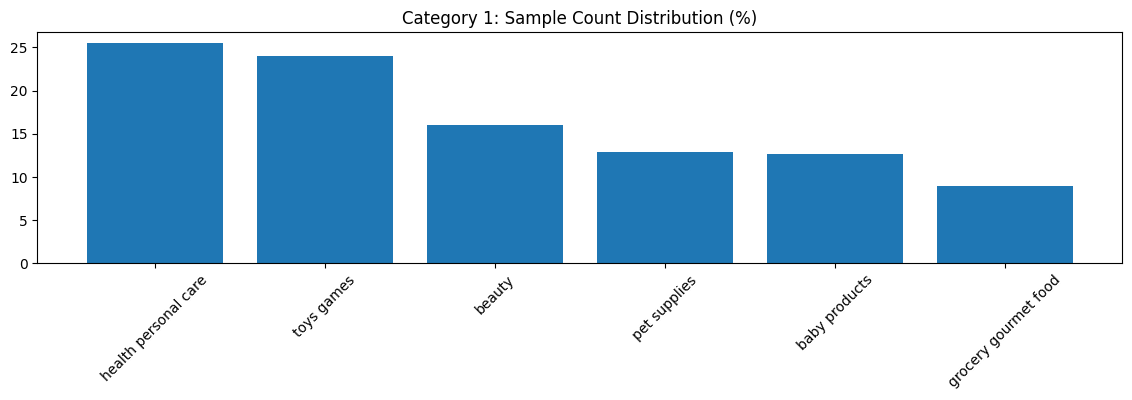

In [18]:
values = (new_df["Cat1"].value_counts(normalize=True) * 100).values.tolist()
columns = (new_df["Cat1"].value_counts(normalize=True) * 100).keys().tolist()

plt.figure(figsize=(14, 3))
plt.bar(columns, values)
plt.xticks(rotation=45)  
plt.title("Category 1: Sample Count Distribution (%)")
plt.show()

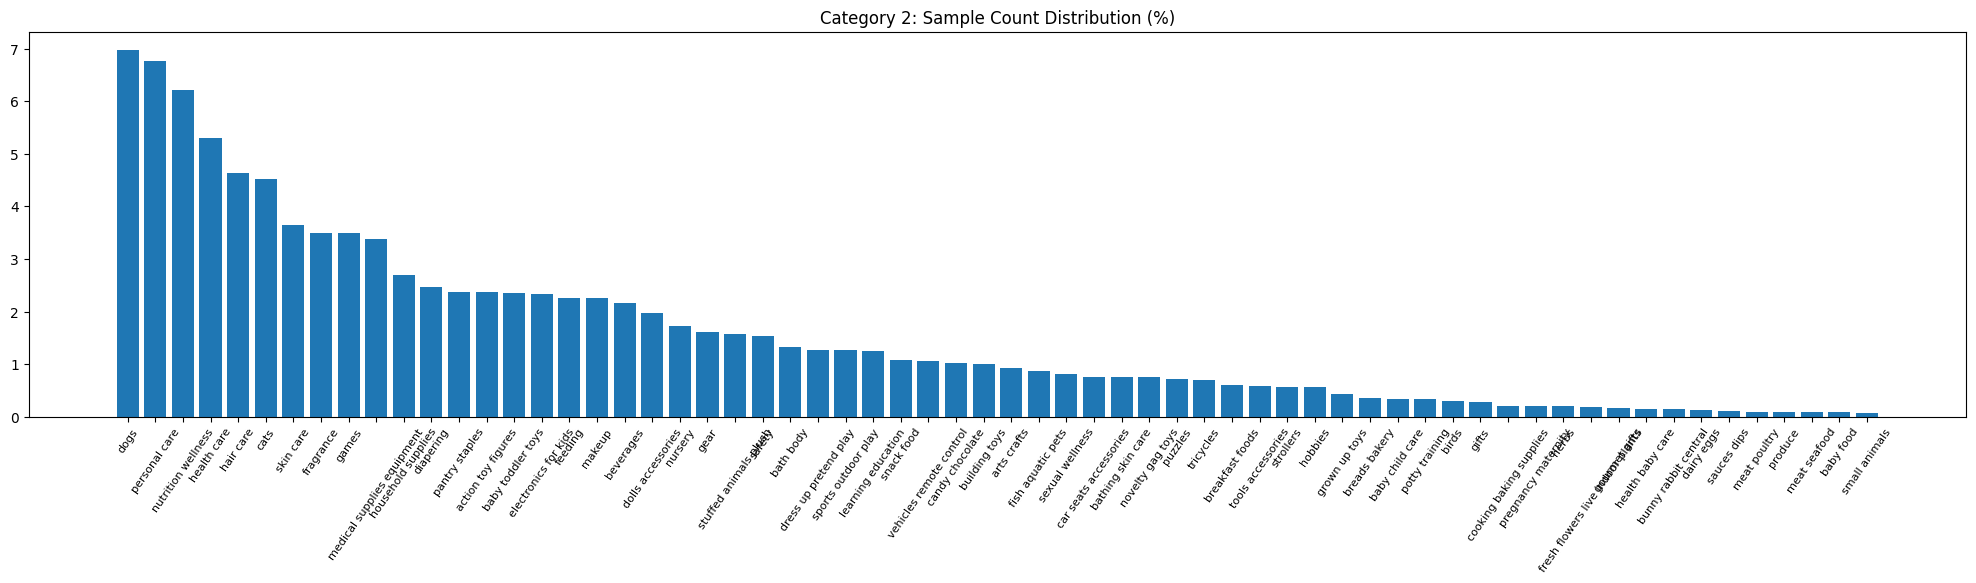

In [19]:
values = (new_df["Cat2"].value_counts(normalize=True) * 100).values.tolist()
columns = (new_df["Cat2"].value_counts(normalize=True) * 100).keys().tolist()

plt.figure(figsize=(25, 5))
plt.bar(columns, values)
plt.xticks(rotation=55, fontsize=8)  
plt.title("Category 2: Sample Count Distribution (%)")
plt.show()

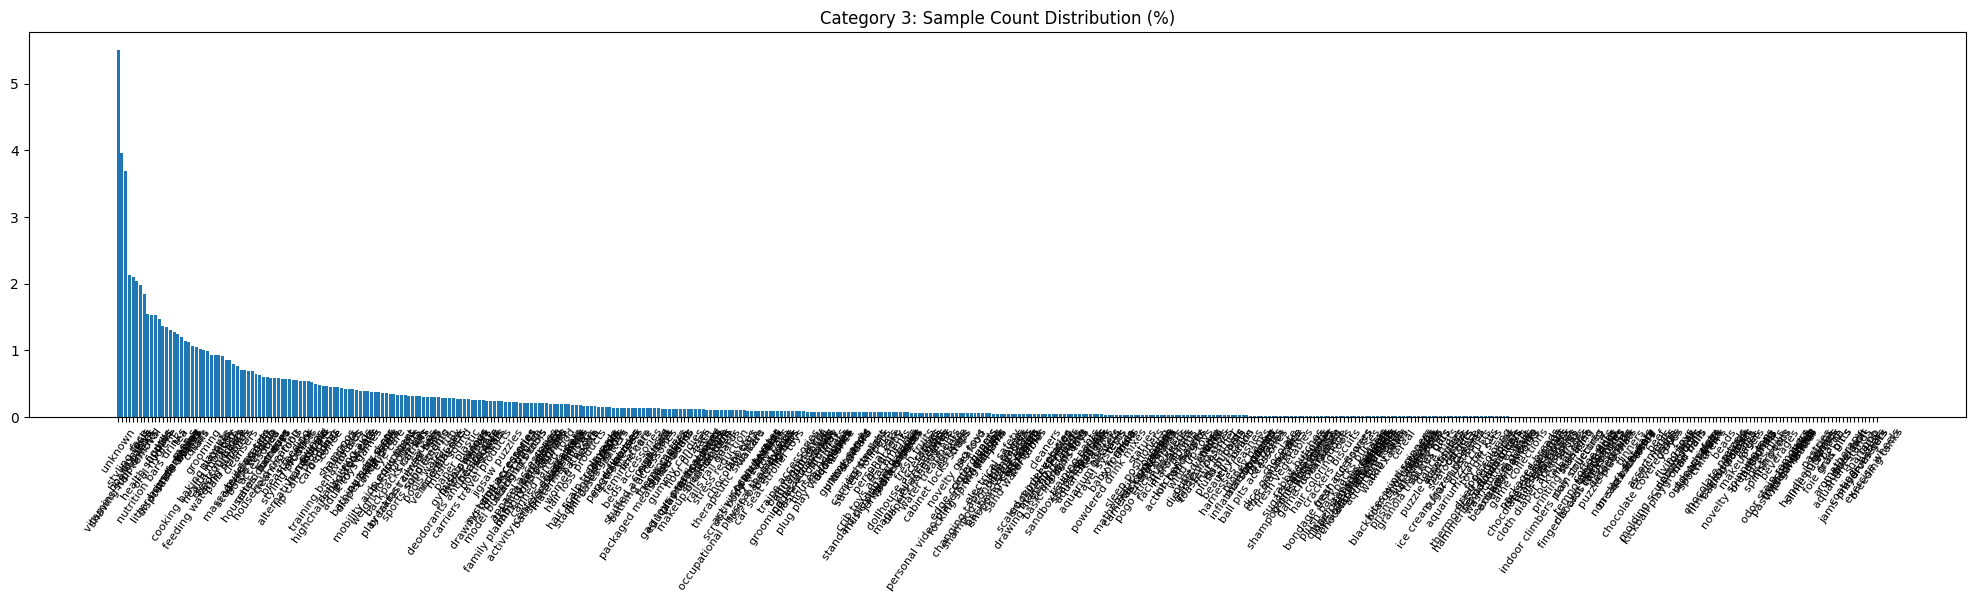

In [20]:
values = (new_df["Cat3"].value_counts(normalize=True) * 100).values.tolist()
columns = (new_df["Cat3"].value_counts(normalize=True) * 100).keys().tolist()

plt.figure(figsize=(25, 5))
plt.bar(columns, values)
plt.xticks(rotation=55, fontsize=8)  
plt.title("Category 3: Sample Count Distribution (%)")
plt.show()

The "Unknown" seems to be a problem! but lets keep it for now ...

Now we need to check the Format and Distribution properties

In [21]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49979 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        49979 non-null  object 
 1   Helpfulness  49979 non-null  object 
 2   Score        49979 non-null  float64
 3   Text         49979 non-null  object 
 4   Cat1         49979 non-null  object 
 5   Cat2         49979 non-null  object 
 6   Cat3         49979 non-null  object 
dtypes: float64(1), object(6)
memory usage: 3.1+ MB


Now need to modify the Data Types

In [22]:
new_df["Helpfulness"].unique()

array(['0/0', '2/4', '2/2', '1/1', '1/6', '9/9', '1/2', '20/24', '18/19',
       '3/3', '20/20', '36/36', '26/26', '5/7', '1/5', '6/7', '67/71',
       '5/8', '7/10', '12/14', '12/12', '34/37', '8/8', '21/22', '77/83',
       '118/125', '0/3', '9/10', '5/6', '44/44', '15/15', '3/6', '17/18',
       '35/37', '0/2', '34/35', '23/31', '31/33', '0/1', '37/37', '13/15',
       '36/38', '124/130', '3/5', '21/21', '29/36', '14/15', '11/11',
       '18/18', '7/8', '42/45', '5/5', '5/13', '74/74', '10/13', '3/4',
       '20/21', '21/26', '9/18', '32/36', '6/6', '4/12', '4/4', '59/63',
       '8/13', '22/22', '3/11', '22/24', '8/9', '29/34', '2/3', '1/4',
       '22/23', '16/18', '13/13', '4/8', '23/23', '1/7', '24/24', '47/47',
       '16/17', '31/31', '21/37', '7/7', '54/55', '3/33', '43/46',
       '51/51', '48/54', '6/8', '58/60', '26/32', '51/67', '28/29', '4/6',
       '34/34', '62/66', '11/12', '40/41', '26/27', '1/3', '139/141',
       '11/14', '19/19', '26/30', '141/143', '33/37', '4/5'

In [23]:
def encode_helpfulness(x):
    val_1, val_2 = map(float, x.split('/'))
    # Division by 0 (Error)
    if val_2 == 0:
        new_val = 0
    else:
        new_val = val_1 / val_2
    
    return new_val

In [24]:
new_df.head()

,Title,Helpfulness,Score,Text,Cat1,Cat2,Cat3
0,Golden Valley Natural Buffalo Jerky,0/0,3.0,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,Westing Game,0/0,5.0,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,Westing Game,0/0,5.0,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown
3,Westing Game,0/0,5.0,I got the book at my bookfair at school lookin...,toys games,games,unknown
4,I SPY A is For Jigsaw Puzzle 63pc,2/4,5.0,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,jigsaw puzzles


In [25]:
new_df['Helpfulness'] = new_df['Helpfulness'].apply(encode_helpfulness)

In [26]:
new_df.head()

,Title,Helpfulness,Score,Text,Cat1,Cat2,Cat3
0,Golden Valley Natural Buffalo Jerky,0.0,3.0,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,Westing Game,0.0,5.0,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,Westing Game,0.0,5.0,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown
3,Westing Game,0.0,5.0,I got the book at my bookfair at school lookin...,toys games,games,unknown
4,I SPY A is For Jigsaw Puzzle 63pc,0.5,5.0,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,jigsaw puzzles


now lets have a look at data dist info

In [27]:
new_df.describe()

,Helpfulness,Score
count,49979.000000,49979.000000
mean,0.427391,4.099322
std,0.465299,1.342018
min,0.000000,1.000000
25%,0.000000,4.000000
50%,0.000000,5.000000
75%,1.000000,5.000000
max,1.000000,5.000000


Better to scale the "Score" values too, although they dont seem be so much distant compared to "Helpfulness" in scale of values

In [28]:
scaler = MinMaxScaler()
new_df["Score"] = scaler.fit_transform(new_df[["Score"]])  
new_df.describe()

,Helpfulness,Score
count,49979.000000,49979.000000
mean,0.427391,0.774830
std,0.465299,0.335504
min,0.000000,0.000000
25%,0.000000,0.750000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


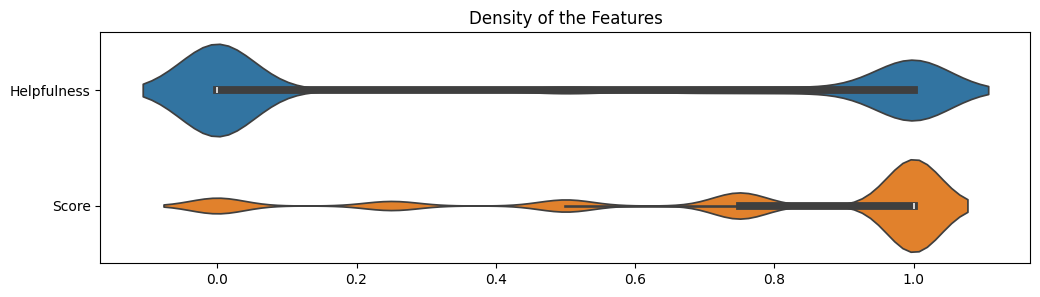

In [29]:
plt.figure(figsize=(12, 3))
sns.violinplot(data=new_df[new_df.columns[1:3]], orient='h')
plt.title("Density of the Features")
plt.show()

In [30]:
new_df.head(5)

,Title,Helpfulness,Score,Text,Cat1,Cat2,Cat3
0,Golden Valley Natural Buffalo Jerky,0.0,0.5,The description and photo on this product need...,grocery gourmet food,meat poultry,jerky
1,Westing Game,0.0,1.0,This was a great book!!!! It is well thought t...,toys games,games,unknown
2,Westing Game,0.0,1.0,"I am a first year teacher, teaching 5th grade....",toys games,games,unknown
3,Westing Game,0.0,1.0,I got the book at my bookfair at school lookin...,toys games,games,unknown
4,I SPY A is For Jigsaw Puzzle 63pc,0.5,1.0,Hi! I'm Martine Redman and I created this puzz...,toys games,puzzles,jigsaw puzzles


Now lets clean the "Text" column

In [31]:
stop_words = set(stopwords.words('english'))

In [32]:
def clean_text(text):
    """Simple function to clean the input text by removing Junks"""
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)  
    # Remove stopwords
    text = ' '.join(word for word in text.split() if word not in stop_words)  
    return text


In [33]:
new_df['Text'] = new_df['Text'].apply(clean_text)
new_df['Title'] = new_df['Title'].apply(clean_text)
new_df.head()

,Title,Helpfulness,Score,Text,Cat1,Cat2,Cat3
0,golden valley natural buffalo jerky,0.0,0.5,description photo product needs changed indica...,grocery gourmet food,meat poultry,jerky
1,westing game,0.0,1.0,great book well thought easily imagine events ...,toys games,games,unknown
2,westing game,0.0,1.0,first year teacher teaching th grade special r...,toys games,games,unknown
3,westing game,0.0,1.0,got book bookfair school looking something sum...,toys games,games,unknown
4,spy jigsaw puzzle pc,0.5,1.0,hi im martine redman created puzzle briarpatch...,toys games,puzzles,jigsaw puzzles


As you can see the junks have been removed from the "Text". For example the second row had "!!!" after "book"

Now Lets extract some features from it ...

In [34]:
# To know how many unique tokens we propably going to need lets see the len of each review sample
new_df["Review_Len"] = new_df["Text"].apply(len) 

In [35]:
new_df["Review_Len"].describe()

count    49979.000000
mean       250.321955
std        233.916726
min          0.000000
25%        105.000000
50%        180.000000
75%        312.000000
max       4587.000000
Name: Review_Len, dtype: float64

In [36]:
new_df["Review_Len"].value_counts().sort_values(ascending=False) 

Review_Len
86      273
82      272
80      267
72      257
96      256
       ... 
1129      1
1558      1
1405      1
1891      1
1381      1
Name: count, Length: 1509, dtype: int64

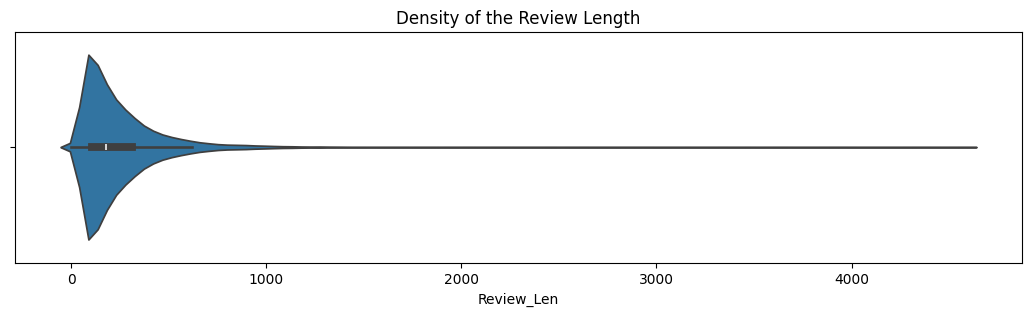

In [37]:
plt.figure(figsize=(13, 3))
sns.violinplot(data=new_df["Review_Len"], orient='h')
plt.title("Density of the Review Length")
plt.show()

Longest review had about 4.5k words. Considering that some of those words are possibly shared, we assume that 3.5k number of tokens (featrues) would be a valid value to begin with. Also we drop the rows that had no reviews. (Len zero)

In [38]:
print(f"Shape before: {new_df.shape}")
new_df.drop(new_df[new_df["Review_Len"] == 0.0].index, inplace=True)
print(f"Shape after: {new_df.shape}")

Shape before: (49979, 8)
Shape after: (49971, 8)


In [39]:
review_vectorizer = TfidfVectorizer(max_features=1500, min_df=5, ngram_range=(1, 2)) # reduced after try-capture experiments

In [40]:
X_1 = review_vectorizer.fit_transform(new_df['Text']).toarray() # we can also test the performance while keeping the matrix Sparse
X_1

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.17462187, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(49971, 1500))

Now we need to do the same thing with Title

In [41]:
del df # No longer needed
# To know how many unique tokens we propably going to need lets see the len of each review sample
new_df["Title_Len"] = new_df["Title"].apply(len) 

In [42]:
new_df["Title_Len"].describe()

count    49971.000000
mean        38.828961
std         17.283259
min          0.000000
25%         27.000000
50%         37.000000
75%         48.000000
max        399.000000
Name: Title_Len, dtype: float64

In [43]:
new_df["Title_Len"].value_counts().sort_values(ascending=False) 

Title_Len
34     1487
33     1436
42     1423
32     1360
36     1348
       ... 
160       1
120       1
318       1
138       1
284       1
Name: count, Length: 158, dtype: int64

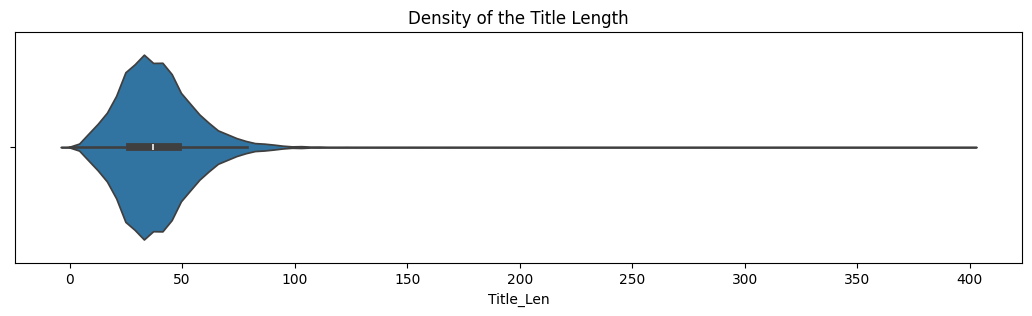

In [44]:
plt.figure(figsize=(13, 3))
sns.violinplot(data=new_df["Title_Len"], orient='h')
plt.title("Density of the Title Length")
plt.show()

lets Keep the titles intact for now and just extract features from it

In [45]:
title_vectorizer = TfidfVectorizer(max_features = 400, min_df=5, ngram_range=(1, 2)) # same as review but here the max length of title is 480 so we decided to pick 350 

In [46]:
X_2 = title_vectorizer.fit_transform(new_df['Title']).toarray() # we can also test the performance while keeping the matrix Sparse
X_2

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(49971, 400))

In [47]:
X = np.hstack((X_1, X_2, new_df[['Helpfulness', 'Score']].values))
X

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.5       ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.75      ],
       [0.        , 0.17462187, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]], shape=(49971, 1902))

In [48]:
new_df.head(3) # just to verify the matrix

,Title,Helpfulness,Score,Text,Cat1,Cat2,Cat3,Review_Len,Title_Len
0,golden valley natural buffalo jerky,0.0,0.5,description photo product needs changed indica...,grocery gourmet food,meat poultry,jerky,84,35
1,westing game,0.0,1.0,great book well thought easily imagine events ...,toys games,games,unknown,167,12
2,westing game,0.0,1.0,first year teacher teaching th grade special r...,toys games,games,unknown,328,12


In [49]:
X.shape # should be 49971, 3352

(49971, 1902)

In [50]:
# Validating the operation
z = 0
nz = 0
    
for k in tqdm(X[:][:].flatten()): # should be 214975242
    if k != 0.0:
        # print(k)
        nz +=1
    else:
        # print("zero")
        z +=1

print(f"zeroes: {z/(z+nz)}\nnon-zeroes: {nz/(z+nz)}")

100%|███████████████████████████████████████████| 95044842/95044842 [00:33<00:00, 2853837.42it/s]

zeroes: 0.9851688006383345
non-zeroes: 0.014831199361665518


In [51]:
new_df.shape[0] == X.shape[0] # Sanity Chech

True

So now we add new columns to each row (per sample) representing the values of tf-idf

In [52]:
df = pd.DataFrame(X, columns=[str(i) for i in range(X.shape[1])])
df.shape

(49971, 1902)

In [53]:
new_df = new_df.reset_index(drop=True)
df = df.reset_index(drop=True)

In [54]:
# Putting them altogether
data = pd.concat([new_df, df], axis=1)
# Drop "Title" and "Text" Columns
data.drop(data[["Title", "Text"]], axis=1 , inplace=True) 

data.shape # 49971,2459

(49971, 1909)

In [55]:
del df, new_df #  No Longer Neede
data.head()

,Helpfulness,Score,Cat1,Cat2,Cat3,Review_Len,Title_Len,0,1,2,...,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901
0,0.0,0.5,grocery gourmet food,meat poultry,jerky,84,35,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
1,0.0,1.0,toys games,games,unknown,167,12,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,toys games,games,unknown,328,12,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,toys games,games,unknown,311,12,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.5,1.0,toys games,puzzles,jigsaw puzzles,464,20,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0


Now we need to encode the values "Cat1", "Cat2" and "Cat3"

In [56]:
level_1_labels = data[["Cat1"]]
level_2_labels = data[["Cat2"]]
level_3_labels = data[["Cat3"]]
data.drop(data[["Cat1", "Cat2", "Cat3"]], axis=1 , inplace=True) 
data.head()

,Helpfulness,Score,Review_Len,Title_Len,0,1,2,3,4,5,...,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901
0,0.0,0.5,84,35,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
1,0.0,1.0,167,12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,328,12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,311,12,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.5,1.0,464,20,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0


We should also scale the values of "Review_Len" and "Title_Len" columns if we intend to keep them

In [57]:
scaler = MinMaxScaler()
data["Review_Len"] = scaler.fit_transform(data[["Review_Len"]])  
data["Title_Len"] = scaler.fit_transform(data[["Title_Len"]])  
data.head(3)

,Helpfulness,Score,Review_Len,Title_Len,0,1,2,3,4,5,...,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901
0,0.0,0.5,0.017884,0.087719,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
1,0.0,1.0,0.035987,0.030075,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.071101,0.030075,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


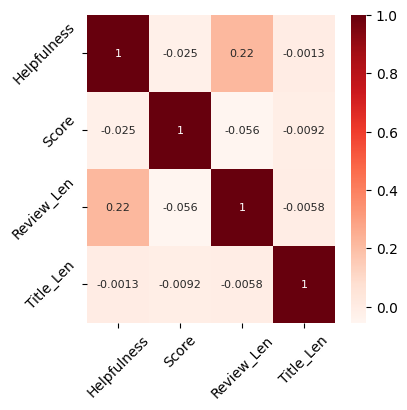

In [58]:
corr = data.iloc[:, :4].corr() # Only the first 4 features
plt.figure(figsize=(4,4))
sns.heatmap(corr,annot=True,annot_kws={'size':8},cmap='Reds')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# Initial Benchmarking

### Dont run these cells!

In [59]:
# setup(data, 
#       target = level_1_labels["Cat1"],
#       session_id = 110,
#       preprocess = True,
#       verbose=True,
#       fold =5,
#       fix_imbalance=True) 

In [60]:
# compare_models(sort="f1", errors = 'raise', fold=5, include = ['lr', 'svm', 'knn', 'rf', 'lightgbm'])

In [61]:
# cat_1_model = create_model('lightgbm')

In [62]:
# model_1 = finalize_model(cat_1_model)

LGBM (Light Gradient Boosting Machine) is our choice here. As this model have more hyperparameters compared to SVM and Logistic Regressor (broader search space) that increases the chance of finding dominant model in parameter space. 

Lets fine-tune the model to minimize errors at the first level of the hierarchy, ensuring greater accuracy before progressing to the next classification levels.

In [63]:
# tune_model(lgbm, n_iter=20, fold=5) # takes so much time to run ...

### First Approach Ended
This approach while being valid, does not handle the heirachy directly. We trained multiple simoultinous models (blind to other level labels) on each category set and fed the data all at the same time to them. This approach while being valid is prone to make mistakes regarding the heirachy of labels.

# Second Approach Begins
The idea is to design a new loss function that penalizes the mistakes in predictions with an ordinal behaviour respecting their position in heirachy. 

For example if during the training the model makes a mistake in classifying the level one (Cat1) label it should get much higher penalty than the incidents where it makes same mistake but on second or third level. This is because, the mistakes on the initial levels would drastically increase the error and should be avoided. Its simmialr to pruning in tree search algorithms.

In [64]:
train_size = 40000
X_train = data.iloc[:train_size]  
X_valid = data.iloc[train_size:]  

In [65]:
X_train

,Helpfulness,Score,Review_Len,Title_Len,0,1,2,3,4,5,...,1892,1893,1894,1895,1896,1897,1898,1899,1900,1901
0,0.0,0.50,0.017884,0.087719,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50
1,0.0,1.00,0.035987,0.030075,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
2,0.0,1.00,0.071101,0.030075,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
3,0.0,1.00,0.067394,0.030075,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
4,0.5,1.00,0.100763,0.050125,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.0,1.00,0.011996,0.087719,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00
39996,0.0,0.25,0.025082,0.117794,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25
39997,1.0,0.75,0.044929,0.127820,0.00000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.75
39998,0.0,1.00,0.025300,0.085213,0.24923,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.00


In [66]:
# Encode labels
encoded_labels_1, encoded_labels_2, encoded_labels_3 = LabelEncoder(), LabelEncoder(), LabelEncoder()
y1 = encoded_labels_1.fit_transform(level_1_labels["Cat1"])
y2 = encoded_labels_2.fit_transform(level_2_labels["Cat2"])
y3 = encoded_labels_3.fit_transform(level_3_labels["Cat3"])

In [67]:
y1

array([2, 5, 5, ..., 4, 4, 3], shape=(49971,))

In [68]:
y_train = np.column_stack((y1[:train_size], y2[:train_size], y3[:train_size]))  
y_valid = np.column_stack((y1[train_size:], y2[train_size:], y3[train_size:]))  

In [69]:
y_valid

array([[  3,  34, 188],
       [  1,  39, 169],
       [  4,  19, 210],
       ...,
       [  4,  19,  82],
       [  4,  19, 448],
       [  3,  42, 304]], shape=(9971, 3))

In [70]:
y_train

array([[  2,  40, 249],
       [  5,  27, 457],
       [  5,  27, 457],
       ...,
       [  3,  45, 460],
       [  4,  19, 265],
       [  4,  19, 448]], shape=(40000, 3))

In [71]:
y_valid.shape

(9971, 3)

In [72]:
# Validation labels for evaluation
y_valid1 = y_valid[:, 0]
y_valid2 = y_valid[:, 1]
y_valid3 = y_valid[:, 2]

In [73]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [74]:
def hierarchical_loss(y_true, y_pred, weights=[70.0, 25.0, 5.0], scale=10.0):
    """Custom loss function with ordinal penalties
    weights: [Level 1 penalty, Level 2 penalty, Level 3 penalty]"""
  
    n_samples = y_true.shape[0]
    n_classes1, n_classes2, n_classes3 = len(encoded_labels_1.classes_), len(encoded_labels_2.classes_), len(encoded_labels_3.classes_)
    
    # Predictions per level
    pred1 = y_pred[:, :n_classes1]  # Level 1 logits (Prediction ratios)
    pred2 = y_pred[:, n_classes1:n_classes1 + n_classes2]  # Level 2 ...
    pred3 = y_pred[:, n_classes1 + n_classes2:]  # Level 3 ...
    true1 = y_true[:, 0].astype(int)
    true2 = y_true[:, 1].astype(int)
    true3 = y_true[:, 2].astype(int)
    
    # Calculate the softmax per predicition ratios
    prob1 = softmax(pred1)
    prob2 = softmax(pred2)
    prob3 = softmax(pred3)
    
    # Gradient and Hessian
    grad = np.zeros_like(y_pred)
    hess = np.zeros_like(y_pred)

    # ----------------------------------------------------------------------------------------------------------------------------------------
    # Level 1 updates ===========================================
    grad[:, :n_classes1] = prob1 - np.eye(n_classes1)[true1]
    hess[:, :n_classes1] = prob1 * (1 - prob1)
    
    # grad[:, :n_classes1] *= weights[0] / n_classes1  # Normalize by class count (Since the level 1 has only 6 possible values but level 3 has 500)
    # grad[:, :n_classes1] *= weights[0] / np.log(n_classes1)  # Normalize by log class count 
    grad[:, :n_classes1] *= weights[0] * scale
    # hess[:, :n_classes1] *= weights[0] / n_classes1 # hessian must be a square! (Sh)
    # hess[:, :n_classes1] *= weights[0] / np.log(n_classes1)
    hess[:, :n_classes1] *= weights[0] * scale
    
    
    # Level 2 updates ===========================================
    start = n_classes1
    end = n_classes1 + n_classes2
    grad[:, start:end] = prob2 - np.eye(n_classes2)[true2]
    hess[:, start:end] = prob2 * (1 - prob2)
    
    # grad[:, start:end] *= weights[1] / n_classes2
    # grad[:, start:end] *= weights[1] / np.log(n_classes2)
    grad[:, start:end] *= weights[1] * scale
    # hess[:, start:end] *= weights[1] / n_classes2
    # hess[:, start:end] *= weights[1] / np.log(n_classes2)
    hess[:, start:end] *= weights[1] * scale
    
    # Level 3 updates ===========================================
    start = n_classes1 + n_classes2
    end = start + n_classes3
    grad[:, start:end] = prob3 - np.eye(n_classes3)[true3]
    hess[:, start:end] = prob3 * (1 - prob3)
    
    # grad[:, start:end] *= weights[2] / n_classes3
    # grad[:, start:end] *= weights[2] / np.log(n_classes3)
    grad[:, start:end] *= weights[2] * scale
    # hess[:, start:end] *= weights[2] / n_classes3
    # hess[:, start:end] *= weights[2] / np.log(n_classes3)
    hess[:, start:end] *= weights[2] * scale

    # ----------------------------------------------------------------------------------------------------------------------------------------
    # Debug: Print stats for first few iterations
    # if i < 5:
    #     print(f"Iter {i+1} - Grad mean: {np.mean(grad):.6f}, Grad std: {np.std(grad):.6f}")
    #     print(f"Iter {i+1} - Hess mean: {np.mean(hess):.6f}, Hess std: {np.std(hess):.6f}")
    #     # shape of grad and hess should be printed!

    
    return grad, hess

In [75]:
def objective(y_true, y_pred):
    grad, hess = hierarchical_loss(y_true, y_pred.reshape(-1, total_classes))
    return grad, hess

In [76]:
n_classes1 = len(encoded_labels_1.classes_)
print(f"Number of Cat1 Classes: {n_classes1}")
n_classes2 = len(encoded_labels_2.classes_)
print(f"Number of Cat2 Classes: {n_classes2}")
n_classes3 = len(encoded_labels_3.classes_)
print(f"Number of Cat3 Classes: {n_classes3}")
total_classes = n_classes1 + n_classes2 + n_classes3
print(f"Total number of classes: {total_classes}")

Number of Cat1 Classes: 6
Number of Cat2 Classes: 64
Number of Cat3 Classes: 473
Total number of classes: 543


These cells have been commented and minimized because of shape Mismatch problem with LGBM input format

In [77]:
# # Offset labels to make them unique across levels
# y_train_offset = np.column_stack((
#     y_train[:, 0], 
#     y_train[:, 1] + n_classes1, 
#     y_train[:, 2] + n_classes1 + n_classes2
# ))

In [78]:
# # Offset labels for validation
# y_valid_offset = np.column_stack((
#     y_valid[:, 0], 
#     y_valid[:, 1] + n_classes1, 
#     y_valid[:, 2] + n_classes1 + n_classes2
# ))

In [79]:
# # Convert the DataFrame to LightGBM Dataset
# train_data = lgb.Dataset(X_train, label=y_train_offset)
# valid_data = lgb.Dataset(X_valid, label=y_valid_offset, reference=train_data)

In [80]:
# Use dummy labels for Dataset construction
# train_data = lgb.Dataset(X_train, label=np.zeros(train_size))  
# valid_data = lgb.Dataset(X_valid, label=np.zeros(len(X_valid)), reference=train_data)

np.random.seed(101)
train_data = lgb.Dataset(X_train,
                         label=np.random.randint(0, 543, size=len(X_train))) 

valid_data = lgb.Dataset(X_valid,
                         label=np.random.randint(0, 543, size=len(X_valid)),
                         reference=train_data)

The param set here have gone under multiple updates to resolve the issue of "Too Small and Identical Gradients"

In [81]:
# Model parameters
params = {
    'max_depth': 6,         
    'learning_rate': 0.05,
    'num_leaves': 60,        
    'num_class': total_classes,
    'objective': 'multiclass',
    'min_data_in_leaf': 20,
    'min_sum_hessian_in_leaf': 1e-4,
    'n_jobs': -1,
    'verbose': -1             
}

booster = lgb.Booster(params=params, train_set=train_data)

In [82]:
num_boost_round = 1500
best_loss = float('inf')
best_iteration = 0
patience = 100  # how much it should wait before calling off the LGBM
eval_result = {'validation': {'multi_logloss': []}}

The training loop below also have gone under multiple iterations of improvement. The latest issue is the gradients values being too small and having the std of 0.

In [83]:
def update_gradients(preds, train_set):
    # preds: Predictions from booster.predict()
    # train_set: Ignored here, we use y_train directly
    y_pred_reshaped = preds.reshape(-1, total_classes)
    grad, hess = hierarchical_loss(y_train, y_pred_reshaped)
    return grad, hess


Lets see if the training goes along the path ...

In [84]:
for i in tqdm(range(num_boost_round)):
    # Predict raw scores
    y_pred_train = booster.predict(X_train, raw_score=True)  # Shape: (40000, total_classes)
    y_pred_valid = booster.predict(X_valid, raw_score=True)  # Shape: (~10000, total_classes)

    # # Debug: Check if predictions change
    # if i < 5:
    #     print(f"Iter {i+1} - y_pred_train mean: {np.mean(y_pred_train):.6f}, std: {np.std(y_pred_train):.6f}")
    
    # Update booster with custom gradients
    booster.update(fobj=update_gradients)

    # Compute validation loss
    prob1 = softmax(y_pred_valid[:, :n_classes1])  # Shape: (9971, 6)
    prob2 = softmax(y_pred_valid[:, n_classes1:n_classes1 + n_classes2])  # Shape: (9971, 37) # better to use sigmoid! (SH)
    prob3 = softmax(y_pred_valid[:, n_classes1 + n_classes2:])  # Shape: (9971, 500)

    # Extract probabilities at true labels
    true1 = y_valid[:, 0].astype(int)
    true2 = y_valid[:, 1].astype(int)
    true3 = y_valid[:, 2].astype(int)
    loss1 = -np.mean(np.log(prob1[np.arange(len(true1)), true1] + 1e-10)) # level_1_loss
    loss2 = -np.mean(np.log(prob2[np.arange(len(true2)), true2] + 1e-10)) # level_2_loss
    loss3 = -np.mean(np.log(prob3[np.arange(len(true3)), true3] + 1e-10)) # level_3_loss

    
    # Weighted average of losses [3,2,1]
    valid_loss = (75.0 * loss1 + 20.0 * loss2 + 5.0 * loss3) / 100.0
    eval_result['validation']['multi_logloss'].append(valid_loss)
    print(f"[{i+1}] validation's multi_logloss: {valid_loss:.4f}")

    
    # Early stopping callback
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_iteration = i
    elif i - best_iteration >= patience:
        print(f"Early stopping, best epoch is: [{best_iteration + 1}] Loss: {best_loss:.4f}")
        break

  0%|                                                         | 1/1500 [00:16<6:50:13, 16.42s/it]

[1] validation's multi_logloss: 2.4836


  0%|                                                         | 2/1500 [00:34<7:16:53, 17.50s/it]

[2] validation's multi_logloss: 2.0649


  0%|                                                         | 3/1500 [00:51<7:03:40, 16.98s/it]

[3] validation's multi_logloss: 2.0992


  0%|▏                                                        | 4/1500 [01:08<7:09:44, 17.24s/it]

[4] validation's multi_logloss: 2.0337


  0%|▏                                                        | 5/1500 [01:24<6:52:38, 16.56s/it]

[5] validation's multi_logloss: 1.9956


  0%|▏                                                        | 6/1500 [01:40<6:49:41, 16.45s/it]

[6] validation's multi_logloss: 1.9993


  0%|▎                                                        | 7/1500 [01:56<6:48:01, 16.40s/it]

[7] validation's multi_logloss: 2.0367


  1%|▎                                                        | 8/1500 [02:12<6:47:19, 16.38s/it]

[8] validation's multi_logloss: 2.0992


  1%|▎                                                        | 9/1500 [02:27<6:35:14, 15.91s/it]

[9] validation's multi_logloss: 2.1812


  1%|▎                                                       | 10/1500 [02:45<6:46:51, 16.38s/it]

[10] validation's multi_logloss: 2.2725


  1%|▍                                                       | 11/1500 [03:04<7:06:37, 17.19s/it]

[11] validation's multi_logloss: 2.3651


  1%|▍                                                       | 12/1500 [03:21<7:06:03, 17.18s/it]

[12] validation's multi_logloss: 2.3969


  1%|▍                                                       | 13/1500 [03:30<6:08:22, 14.86s/it]

[13] validation's multi_logloss: 2.4442


  1%|▌                                                       | 14/1500 [03:40<5:26:39, 13.19s/it]

[14] validation's multi_logloss: 2.4194


  1%|▌                                                       | 15/1500 [03:49<4:59:15, 12.09s/it]

[15] validation's multi_logloss: 2.3973


  1%|▌                                                       | 16/1500 [03:59<4:43:18, 11.45s/it]

[16] validation's multi_logloss: 2.3766


  1%|▋                                                       | 17/1500 [04:09<4:28:12, 10.85s/it]

[17] validation's multi_logloss: 2.3564


  1%|▋                                                       | 18/1500 [04:18<4:15:25, 10.34s/it]

[18] validation's multi_logloss: 2.3382


  1%|▋                                                       | 19/1500 [04:27<4:06:49, 10.00s/it]

[19] validation's multi_logloss: 2.3206


  1%|▋                                                       | 20/1500 [04:36<4:00:12,  9.74s/it]

[20] validation's multi_logloss: 2.3046


  1%|▊                                                       | 21/1500 [04:45<3:55:15,  9.54s/it]

[21] validation's multi_logloss: 2.2897


  1%|▊                                                       | 22/1500 [04:54<3:51:18,  9.39s/it]

[22] validation's multi_logloss: 2.2752


  2%|▊                                                       | 23/1500 [05:04<3:52:42,  9.45s/it]

[23] validation's multi_logloss: 2.2619


  2%|▉                                                       | 24/1500 [05:13<3:48:20,  9.28s/it]

[24] validation's multi_logloss: 2.2486


  2%|▉                                                       | 25/1500 [05:21<3:43:37,  9.10s/it]

[25] validation's multi_logloss: 2.2362


  2%|▉                                                       | 26/1500 [05:33<4:03:37,  9.92s/it]

[26] validation's multi_logloss: 2.2249


  2%|█                                                       | 27/1500 [05:47<4:33:22, 11.14s/it]

[27] validation's multi_logloss: 2.2140


  2%|█                                                       | 28/1500 [06:00<4:41:20, 11.47s/it]

[28] validation's multi_logloss: 2.2037


  2%|█                                                       | 29/1500 [06:10<4:35:19, 11.23s/it]

[29] validation's multi_logloss: 2.1934


  2%|█                                                       | 30/1500 [06:20<4:22:15, 10.70s/it]

[30] validation's multi_logloss: 2.1840


  2%|█▏                                                      | 31/1500 [06:29<4:13:23, 10.35s/it]

[31] validation's multi_logloss: 2.1749


  2%|█▏                                                      | 32/1500 [06:39<4:05:35, 10.04s/it]

[32] validation's multi_logloss: 2.1660


  2%|█▏                                                      | 33/1500 [06:48<4:00:37,  9.84s/it]

[33] validation's multi_logloss: 2.1578


  2%|█▎                                                      | 34/1500 [06:57<3:57:43,  9.73s/it]

[34] validation's multi_logloss: 2.1499


  2%|█▎                                                      | 35/1500 [07:07<3:58:18,  9.76s/it]

[35] validation's multi_logloss: 2.1420


  2%|█▎                                                      | 36/1500 [07:17<3:56:23,  9.69s/it]

[36] validation's multi_logloss: 2.1343


  2%|█▍                                                      | 37/1500 [07:26<3:54:32,  9.62s/it]

[37] validation's multi_logloss: 2.1274


  3%|█▍                                                      | 38/1500 [07:36<3:56:14,  9.70s/it]

[38] validation's multi_logloss: 2.1208


  3%|█▍                                                      | 39/1500 [07:47<4:02:26,  9.96s/it]

[39] validation's multi_logloss: 2.1138


  3%|█▍                                                      | 40/1500 [07:57<4:02:01,  9.95s/it]

[40] validation's multi_logloss: 2.1079


  3%|█▌                                                      | 41/1500 [08:07<4:02:06,  9.96s/it]

[41] validation's multi_logloss: 2.1018


  3%|█▌                                                      | 42/1500 [08:16<4:02:02,  9.96s/it]

[42] validation's multi_logloss: 2.0961


  3%|█▌                                                      | 43/1500 [08:29<4:23:00, 10.83s/it]

[43] validation's multi_logloss: 2.0900


  3%|█▋                                                      | 44/1500 [08:40<4:18:01, 10.63s/it]

[44] validation's multi_logloss: 2.0841


  3%|█▋                                                      | 45/1500 [08:50<4:13:53, 10.47s/it]

[45] validation's multi_logloss: 2.0791


  3%|█▋                                                      | 46/1500 [09:00<4:09:44, 10.31s/it]

[46] validation's multi_logloss: 2.0735


  3%|█▊                                                      | 47/1500 [09:10<4:11:13, 10.37s/it]

[47] validation's multi_logloss: 2.0682


  3%|█▊                                                      | 48/1500 [09:20<4:10:54, 10.37s/it]

[48] validation's multi_logloss: 2.0635


  3%|█▊                                                      | 49/1500 [09:31<4:10:29, 10.36s/it]

[49] validation's multi_logloss: 2.0588


  3%|█▊                                                      | 50/1500 [09:41<4:12:16, 10.44s/it]

[50] validation's multi_logloss: 2.0546


  3%|█▉                                                      | 51/1500 [09:52<4:13:14, 10.49s/it]

[51] validation's multi_logloss: 2.0498


  3%|█▉                                                      | 52/1500 [10:03<4:16:41, 10.64s/it]

[52] validation's multi_logloss: 2.0454


  4%|█▉                                                      | 53/1500 [10:15<4:25:36, 11.01s/it]

[53] validation's multi_logloss: 2.0414


  4%|██                                                      | 54/1500 [10:28<4:40:31, 11.64s/it]

[54] validation's multi_logloss: 2.0370


  4%|██                                                      | 55/1500 [10:41<4:50:25, 12.06s/it]

[55] validation's multi_logloss: 2.0327


  4%|██                                                      | 56/1500 [10:52<4:39:22, 11.61s/it]

[56] validation's multi_logloss: 2.0290


  4%|██▏                                                     | 57/1500 [11:04<4:44:06, 11.81s/it]

[57] validation's multi_logloss: 2.0251


  4%|██▏                                                     | 58/1500 [11:15<4:38:21, 11.58s/it]

[58] validation's multi_logloss: 2.0216


  4%|██▏                                                     | 59/1500 [11:28<4:50:00, 12.08s/it]

[59] validation's multi_logloss: 2.0180


  4%|██▏                                                     | 60/1500 [11:42<5:03:58, 12.67s/it]

[60] validation's multi_logloss: 2.0149


  4%|██▎                                                     | 61/1500 [11:56<5:15:24, 13.15s/it]

[61] validation's multi_logloss: 2.0111


  4%|██▎                                                     | 62/1500 [12:10<5:17:26, 13.24s/it]

[62] validation's multi_logloss: 2.0076


  4%|██▎                                                     | 63/1500 [12:23<5:13:22, 13.08s/it]

[63] validation's multi_logloss: 2.0042


  4%|██▍                                                     | 64/1500 [12:35<5:09:51, 12.95s/it]

[64] validation's multi_logloss: 2.0012


  4%|██▍                                                     | 65/1500 [12:47<4:59:34, 12.53s/it]

[65] validation's multi_logloss: 1.9982


  4%|██▍                                                     | 66/1500 [12:58<4:52:13, 12.23s/it]

[66] validation's multi_logloss: 1.9954


  4%|██▌                                                     | 67/1500 [13:10<4:48:40, 12.09s/it]

[67] validation's multi_logloss: 1.9923


  5%|██▌                                                     | 68/1500 [13:22<4:50:11, 12.16s/it]

[68] validation's multi_logloss: 1.9893


  5%|██▌                                                     | 69/1500 [13:34<4:48:59, 12.12s/it]

[69] validation's multi_logloss: 1.9866


  5%|██▌                                                     | 70/1500 [13:46<4:48:28, 12.10s/it]

[70] validation's multi_logloss: 1.9837


  5%|██▋                                                     | 71/1500 [13:58<4:46:18, 12.02s/it]

[71] validation's multi_logloss: 1.9810


  5%|██▋                                                     | 72/1500 [14:10<4:46:16, 12.03s/it]

[72] validation's multi_logloss: 1.9783


  5%|██▋                                                     | 73/1500 [14:23<4:49:04, 12.15s/it]

[73] validation's multi_logloss: 1.9754


  5%|██▊                                                     | 74/1500 [14:35<4:51:14, 12.25s/it]

[74] validation's multi_logloss: 1.9727


  5%|██▊                                                     | 75/1500 [14:48<4:51:19, 12.27s/it]

[75] validation's multi_logloss: 1.9704


  5%|██▊                                                     | 76/1500 [15:00<4:51:04, 12.26s/it]

[76] validation's multi_logloss: 1.9677


  5%|██▊                                                     | 77/1500 [15:12<4:51:24, 12.29s/it]

[77] validation's multi_logloss: 1.9650


  5%|██▉                                                     | 78/1500 [15:26<5:02:05, 12.75s/it]

[78] validation's multi_logloss: 1.9624


  5%|██▉                                                     | 79/1500 [15:39<5:01:07, 12.71s/it]

[79] validation's multi_logloss: 1.9603


  5%|██▉                                                     | 80/1500 [15:51<5:00:49, 12.71s/it]

[80] validation's multi_logloss: 1.9583


  5%|███                                                     | 81/1500 [16:04<5:00:00, 12.69s/it]

[81] validation's multi_logloss: 1.9561


  5%|███                                                     | 82/1500 [16:16<4:58:22, 12.63s/it]

[82] validation's multi_logloss: 1.9541


  6%|███                                                     | 83/1500 [16:29<4:58:19, 12.63s/it]

[83] validation's multi_logloss: 1.9520


  6%|███▏                                                    | 84/1500 [16:42<4:59:40, 12.70s/it]

[84] validation's multi_logloss: 1.9497


  6%|███▏                                                    | 85/1500 [16:55<4:59:19, 12.69s/it]

[85] validation's multi_logloss: 1.9476


  6%|███▏                                                    | 86/1500 [17:08<5:03:46, 12.89s/it]

[86] validation's multi_logloss: 1.9455


  6%|███▏                                                    | 87/1500 [17:21<5:04:37, 12.93s/it]

[87] validation's multi_logloss: 1.9436


  6%|███▎                                                    | 88/1500 [17:34<5:07:52, 13.08s/it]

[88] validation's multi_logloss: 1.9417


  6%|███▎                                                    | 89/1500 [17:48<5:10:10, 13.19s/it]

[89] validation's multi_logloss: 1.9397


  6%|███▎                                                    | 90/1500 [18:01<5:10:22, 13.21s/it]

[90] validation's multi_logloss: 1.9378


  6%|███▍                                                    | 91/1500 [18:14<5:10:12, 13.21s/it]

[91] validation's multi_logloss: 1.9356


  6%|███▍                                                    | 92/1500 [18:28<5:10:50, 13.25s/it]

[92] validation's multi_logloss: 1.9339


  6%|███▍                                                    | 93/1500 [18:41<5:11:15, 13.27s/it]

[93] validation's multi_logloss: 1.9322


  6%|███▌                                                    | 94/1500 [18:54<5:11:25, 13.29s/it]

[94] validation's multi_logloss: 1.9307


  6%|███▌                                                    | 95/1500 [19:08<5:13:41, 13.40s/it]

[95] validation's multi_logloss: 1.9288


  6%|███▌                                                    | 96/1500 [19:22<5:17:25, 13.57s/it]

[96] validation's multi_logloss: 1.9269


  6%|███▌                                                    | 97/1500 [19:36<5:22:41, 13.80s/it]

[97] validation's multi_logloss: 1.9253


  7%|███▋                                                    | 98/1500 [19:50<5:20:07, 13.70s/it]

[98] validation's multi_logloss: 1.9235


  7%|███▋                                                    | 99/1500 [20:04<5:21:01, 13.75s/it]

[99] validation's multi_logloss: 1.9219


  7%|███▋                                                   | 100/1500 [20:17<5:18:36, 13.65s/it]

[100] validation's multi_logloss: 1.9203


  7%|███▋                                                   | 101/1500 [20:31<5:20:50, 13.76s/it]

[101] validation's multi_logloss: 1.9188


  7%|███▋                                                   | 102/1500 [20:45<5:24:46, 13.94s/it]

[102] validation's multi_logloss: 1.9173


  7%|███▊                                                   | 103/1500 [21:00<5:30:13, 14.18s/it]

[103] validation's multi_logloss: 1.9158


  7%|███▊                                                   | 104/1500 [21:15<5:32:00, 14.27s/it]

[104] validation's multi_logloss: 1.9144


  7%|███▊                                                   | 105/1500 [21:29<5:35:28, 14.43s/it]

[105] validation's multi_logloss: 1.9126


  7%|███▉                                                   | 106/1500 [21:44<5:34:11, 14.38s/it]

[106] validation's multi_logloss: 1.9111


  7%|███▉                                                   | 107/1500 [21:58<5:32:32, 14.32s/it]

[107] validation's multi_logloss: 1.9094


  7%|███▉                                                   | 108/1500 [22:13<5:34:21, 14.41s/it]

[108] validation's multi_logloss: 1.9078


  7%|███▉                                                   | 109/1500 [22:28<5:41:01, 14.71s/it]

[109] validation's multi_logloss: 1.9065


  7%|████                                                   | 110/1500 [22:43<5:43:04, 14.81s/it]

[110] validation's multi_logloss: 1.9051


  7%|████                                                   | 111/1500 [22:58<5:41:35, 14.76s/it]

[111] validation's multi_logloss: 1.9037


  7%|████                                                   | 112/1500 [23:13<5:42:34, 14.81s/it]

[112] validation's multi_logloss: 1.9023


  8%|████▏                                                  | 113/1500 [23:28<5:46:18, 14.98s/it]

[113] validation's multi_logloss: 1.9007


  8%|████▏                                                  | 114/1500 [23:43<5:46:20, 14.99s/it]

[114] validation's multi_logloss: 1.8994


  8%|████▏                                                  | 115/1500 [23:58<5:46:05, 14.99s/it]

[115] validation's multi_logloss: 1.8981


  8%|████▎                                                  | 116/1500 [24:13<5:47:30, 15.07s/it]

[116] validation's multi_logloss: 1.8968


  8%|████▎                                                  | 117/1500 [24:28<5:48:46, 15.13s/it]

[117] validation's multi_logloss: 1.8956


  8%|████▎                                                  | 118/1500 [24:44<5:51:15, 15.25s/it]

[118] validation's multi_logloss: 1.8941


  8%|████▎                                                  | 119/1500 [25:00<5:53:50, 15.37s/it]

[119] validation's multi_logloss: 1.8927


  8%|████▍                                                  | 120/1500 [25:15<5:54:32, 15.42s/it]

[120] validation's multi_logloss: 1.8914


  8%|████▍                                                  | 121/1500 [25:31<5:57:46, 15.57s/it]

[121] validation's multi_logloss: 1.8904


  8%|████▍                                                  | 122/1500 [25:47<6:00:07, 15.68s/it]

[122] validation's multi_logloss: 1.8893


  8%|████▌                                                  | 123/1500 [26:03<5:59:00, 15.64s/it]

[123] validation's multi_logloss: 1.8877


  8%|████▌                                                  | 124/1500 [26:18<5:59:29, 15.68s/it]

[124] validation's multi_logloss: 1.8865


  8%|████▌                                                  | 125/1500 [26:34<5:58:29, 15.64s/it]

[125] validation's multi_logloss: 1.8852


  8%|████▌                                                  | 126/1500 [26:50<5:59:56, 15.72s/it]

[126] validation's multi_logloss: 1.8840


  8%|████▋                                                  | 127/1500 [27:06<6:01:23, 15.79s/it]

[127] validation's multi_logloss: 1.8827


  9%|████▋                                                  | 128/1500 [27:22<6:03:57, 15.92s/it]

[128] validation's multi_logloss: 1.8818


  9%|████▋                                                  | 129/1500 [27:38<6:04:34, 15.95s/it]

[129] validation's multi_logloss: 1.8807


  9%|████▊                                                  | 130/1500 [27:54<6:04:45, 15.97s/it]

[130] validation's multi_logloss: 1.8793


  9%|████▊                                                  | 131/1500 [28:11<6:07:49, 16.12s/it]

[131] validation's multi_logloss: 1.8783


  9%|████▊                                                  | 132/1500 [28:26<6:05:13, 16.02s/it]

[132] validation's multi_logloss: 1.8772


  9%|████▉                                                  | 133/1500 [28:42<6:04:27, 16.00s/it]

[133] validation's multi_logloss: 1.8759


  9%|████▉                                                  | 134/1500 [28:59<6:06:08, 16.08s/it]

[134] validation's multi_logloss: 1.8748


  9%|████▉                                                  | 135/1500 [29:15<6:08:20, 16.19s/it]

[135] validation's multi_logloss: 1.8736


  9%|████▉                                                  | 136/1500 [29:31<6:08:06, 16.19s/it]

[136] validation's multi_logloss: 1.8725


  9%|█████                                                  | 137/1500 [29:48<6:13:37, 16.45s/it]

[137] validation's multi_logloss: 1.8716


  9%|█████                                                  | 138/1500 [30:05<6:13:32, 16.46s/it]

[138] validation's multi_logloss: 1.8708


  9%|█████                                                  | 139/1500 [30:21<6:12:55, 16.44s/it]

[139] validation's multi_logloss: 1.8698


  9%|█████▏                                                 | 140/1500 [30:38<6:16:12, 16.60s/it]

[140] validation's multi_logloss: 1.8687


  9%|█████▏                                                 | 141/1500 [30:55<6:19:47, 16.77s/it]

[141] validation's multi_logloss: 1.8680


  9%|█████▏                                                 | 142/1500 [31:12<6:21:27, 16.85s/it]

[142] validation's multi_logloss: 1.8669


 10%|█████▏                                                 | 143/1500 [31:29<6:23:04, 16.94s/it]

[143] validation's multi_logloss: 1.8660


 10%|█████▎                                                 | 144/1500 [31:47<6:24:05, 17.00s/it]

[144] validation's multi_logloss: 1.8651


 10%|█████▎                                                 | 145/1500 [32:03<6:23:40, 16.99s/it]

[145] validation's multi_logloss: 1.8642


 10%|█████▎                                                 | 146/1500 [32:20<6:21:28, 16.90s/it]

[146] validation's multi_logloss: 1.8633


 10%|█████▍                                                 | 147/1500 [32:37<6:22:28, 16.96s/it]

[147] validation's multi_logloss: 1.8622


 10%|█████▍                                                 | 148/1500 [32:54<6:20:56, 16.91s/it]

[148] validation's multi_logloss: 1.8614


 10%|█████▍                                                 | 149/1500 [33:11<6:21:04, 16.92s/it]

[149] validation's multi_logloss: 1.8604


 10%|█████▌                                                 | 150/1500 [33:28<6:21:43, 16.97s/it]

[150] validation's multi_logloss: 1.8594


 10%|█████▌                                                 | 151/1500 [33:46<6:24:33, 17.10s/it]

[151] validation's multi_logloss: 1.8586


 10%|█████▌                                                 | 152/1500 [34:03<6:23:34, 17.07s/it]

[152] validation's multi_logloss: 1.8578


 10%|█████▌                                                 | 153/1500 [34:20<6:24:25, 17.12s/it]

[153] validation's multi_logloss: 1.8569


 10%|█████▋                                                 | 154/1500 [34:37<6:23:51, 17.11s/it]

[154] validation's multi_logloss: 1.8562


 10%|█████▋                                                 | 155/1500 [34:54<6:26:38, 17.25s/it]

[155] validation's multi_logloss: 1.8553


 10%|█████▋                                                 | 156/1500 [35:12<6:29:47, 17.40s/it]

[156] validation's multi_logloss: 1.8545


 10%|█████▊                                                 | 157/1500 [35:30<6:30:42, 17.46s/it]

[157] validation's multi_logloss: 1.8539


 11%|█████▊                                                 | 158/1500 [35:48<6:34:46, 17.65s/it]

[158] validation's multi_logloss: 1.8530


 11%|█████▊                                                 | 159/1500 [36:05<6:34:18, 17.64s/it]

[159] validation's multi_logloss: 1.8522


 11%|█████▊                                                 | 160/1500 [36:24<6:38:06, 17.83s/it]

[160] validation's multi_logloss: 1.8515


 11%|█████▉                                                 | 161/1500 [36:41<6:35:48, 17.74s/it]

[161] validation's multi_logloss: 1.8507


 11%|█████▉                                                 | 162/1500 [36:59<6:34:45, 17.70s/it]

[162] validation's multi_logloss: 1.8500


 11%|█████▉                                                 | 163/1500 [37:17<6:34:18, 17.70s/it]

[163] validation's multi_logloss: 1.8492


 11%|██████                                                 | 164/1500 [37:35<6:37:16, 17.84s/it]

[164] validation's multi_logloss: 1.8484


 11%|██████                                                 | 165/1500 [37:53<6:41:48, 18.06s/it]

[165] validation's multi_logloss: 1.8478


 11%|██████                                                 | 166/1500 [38:11<6:41:16, 18.05s/it]

[166] validation's multi_logloss: 1.8469


 11%|██████                                                 | 167/1500 [38:29<6:39:45, 17.99s/it]

[167] validation's multi_logloss: 1.8461


 11%|██████▏                                                | 168/1500 [38:47<6:38:24, 17.95s/it]

[168] validation's multi_logloss: 1.8452


 11%|██████▏                                                | 169/1500 [39:05<6:39:04, 17.99s/it]

[169] validation's multi_logloss: 1.8444


 11%|██████▏                                                | 170/1500 [39:23<6:37:20, 17.92s/it]

[170] validation's multi_logloss: 1.8439


 11%|██████▎                                                | 171/1500 [39:42<6:45:01, 18.29s/it]

[171] validation's multi_logloss: 1.8430


 11%|██████▎                                                | 172/1500 [40:01<6:46:47, 18.38s/it]

[172] validation's multi_logloss: 1.8423


 12%|██████▎                                                | 173/1500 [40:20<6:49:52, 18.53s/it]

[173] validation's multi_logloss: 1.8416


 12%|██████▍                                                | 174/1500 [40:38<6:48:46, 18.50s/it]

[174] validation's multi_logloss: 1.8408


 12%|██████▍                                                | 175/1500 [40:57<6:50:35, 18.59s/it]

[175] validation's multi_logloss: 1.8401


 12%|██████▍                                                | 176/1500 [41:16<6:53:00, 18.72s/it]

[176] validation's multi_logloss: 1.8393


 12%|██████▍                                                | 177/1500 [41:35<6:54:20, 18.79s/it]

[177] validation's multi_logloss: 1.8386


 12%|██████▌                                                | 178/1500 [41:54<6:56:35, 18.91s/it]

[178] validation's multi_logloss: 1.8379


 12%|██████▌                                                | 179/1500 [42:13<6:54:35, 18.83s/it]

[179] validation's multi_logloss: 1.8372


 12%|██████▌                                                | 180/1500 [42:31<6:54:42, 18.85s/it]

[180] validation's multi_logloss: 1.8366


 12%|██████▋                                                | 181/1500 [42:50<6:51:09, 18.70s/it]

[181] validation's multi_logloss: 1.8358


 12%|██████▋                                                | 182/1500 [43:09<6:51:00, 18.71s/it]

[182] validation's multi_logloss: 1.8351


 12%|██████▋                                                | 183/1500 [43:27<6:51:47, 18.76s/it]

[183] validation's multi_logloss: 1.8343


 12%|██████▋                                                | 184/1500 [43:46<6:51:47, 18.77s/it]

[184] validation's multi_logloss: 1.8337


 12%|██████▊                                                | 185/1500 [44:05<6:54:24, 18.91s/it]

[185] validation's multi_logloss: 1.8331


 12%|██████▊                                                | 186/1500 [44:27<7:09:27, 19.61s/it]

[186] validation's multi_logloss: 1.8324


 12%|██████▊                                                | 187/1500 [44:46<7:04:22, 19.39s/it]

[187] validation's multi_logloss: 1.8318


 13%|██████▉                                                | 188/1500 [45:05<7:03:37, 19.37s/it]

[188] validation's multi_logloss: 1.8310


 13%|██████▉                                                | 189/1500 [45:25<7:07:21, 19.56s/it]

[189] validation's multi_logloss: 1.8304


 13%|██████▉                                                | 190/1500 [45:45<7:07:33, 19.58s/it]

[190] validation's multi_logloss: 1.8296


 13%|███████                                                | 191/1500 [46:05<7:12:08, 19.81s/it]

[191] validation's multi_logloss: 1.8291


 13%|███████                                                | 192/1500 [46:25<7:11:27, 19.79s/it]

[192] validation's multi_logloss: 1.8286


 13%|███████                                                | 193/1500 [46:45<7:14:28, 19.95s/it]

[193] validation's multi_logloss: 1.8280


 13%|███████                                                | 194/1500 [47:05<7:11:52, 19.84s/it]

[194] validation's multi_logloss: 1.8274


 13%|███████▏                                               | 195/1500 [47:25<7:12:26, 19.88s/it]

[195] validation's multi_logloss: 1.8267


 13%|███████▏                                               | 196/1500 [47:44<7:12:49, 19.92s/it]

[196] validation's multi_logloss: 1.8261


 13%|███████▏                                               | 197/1500 [48:04<7:12:34, 19.92s/it]

[197] validation's multi_logloss: 1.8257


 13%|███████▎                                               | 198/1500 [48:25<7:15:49, 20.08s/it]

[198] validation's multi_logloss: 1.8250


 13%|███████▎                                               | 199/1500 [48:45<7:13:16, 19.98s/it]

[199] validation's multi_logloss: 1.8244


 13%|███████▎                                               | 200/1500 [49:05<7:13:26, 20.01s/it]

[200] validation's multi_logloss: 1.8240


 13%|███████▎                                               | 201/1500 [49:25<7:12:13, 19.96s/it]

[201] validation's multi_logloss: 1.8235


 13%|███████▍                                               | 202/1500 [49:45<7:15:30, 20.13s/it]

[202] validation's multi_logloss: 1.8229


 14%|███████▍                                               | 203/1500 [50:05<7:14:33, 20.10s/it]

[203] validation's multi_logloss: 1.8224


 14%|███████▍                                               | 204/1500 [50:25<7:13:24, 20.07s/it]

[204] validation's multi_logloss: 1.8217


 14%|███████▌                                               | 205/1500 [50:46<7:15:57, 20.20s/it]

[205] validation's multi_logloss: 1.8213


 14%|███████▌                                               | 206/1500 [51:06<7:18:34, 20.34s/it]

[206] validation's multi_logloss: 1.8207


 14%|███████▌                                               | 207/1500 [51:27<7:23:52, 20.60s/it]

[207] validation's multi_logloss: 1.8201


 14%|███████▋                                               | 208/1500 [51:48<7:21:35, 20.51s/it]

[208] validation's multi_logloss: 1.8196


 14%|███████▋                                               | 209/1500 [52:08<7:20:17, 20.46s/it]

[209] validation's multi_logloss: 1.8190


 14%|███████▋                                               | 210/1500 [52:28<7:19:04, 20.42s/it]

[210] validation's multi_logloss: 1.8185


 14%|███████▋                                               | 211/1500 [52:49<7:19:42, 20.47s/it]

[211] validation's multi_logloss: 1.8180


 14%|███████▊                                               | 212/1500 [53:10<7:20:28, 20.52s/it]

[212] validation's multi_logloss: 1.8175


 14%|███████▊                                               | 213/1500 [53:30<7:19:40, 20.50s/it]

[213] validation's multi_logloss: 1.8171


 14%|███████▊                                               | 214/1500 [53:51<7:20:07, 20.53s/it]

[214] validation's multi_logloss: 1.8165


 14%|███████▉                                               | 215/1500 [54:11<7:20:26, 20.57s/it]

[215] validation's multi_logloss: 1.8159


 14%|███████▉                                               | 216/1500 [54:32<7:21:45, 20.64s/it]

[216] validation's multi_logloss: 1.8153


 14%|███████▉                                               | 217/1500 [54:53<7:23:12, 20.73s/it]

[217] validation's multi_logloss: 1.8148


 15%|███████▉                                               | 218/1500 [55:14<7:26:22, 20.89s/it]

[218] validation's multi_logloss: 1.8143


 15%|████████                                               | 219/1500 [55:36<7:28:41, 21.02s/it]

[219] validation's multi_logloss: 1.8138


 15%|████████                                               | 220/1500 [55:57<7:27:18, 20.97s/it]

[220] validation's multi_logloss: 1.8134


 15%|████████                                               | 221/1500 [56:17<7:25:22, 20.89s/it]

[221] validation's multi_logloss: 1.8129


 15%|████████▏                                              | 222/1500 [56:39<7:28:06, 21.04s/it]

[222] validation's multi_logloss: 1.8124


 15%|████████▏                                              | 223/1500 [57:00<7:26:33, 20.98s/it]

[223] validation's multi_logloss: 1.8120


 15%|████████▏                                              | 224/1500 [57:20<7:25:38, 20.95s/it]

[224] validation's multi_logloss: 1.8114


 15%|████████▎                                              | 225/1500 [57:42<7:31:03, 21.23s/it]

[225] validation's multi_logloss: 1.8110


 15%|████████▎                                              | 226/1500 [58:04<7:31:26, 21.26s/it]

[226] validation's multi_logloss: 1.8105


 15%|████████▎                                              | 227/1500 [58:25<7:29:58, 21.21s/it]

[227] validation's multi_logloss: 1.8101


 15%|████████▎                                              | 228/1500 [58:46<7:31:07, 21.28s/it]

[228] validation's multi_logloss: 1.8096


 15%|████████▍                                              | 229/1500 [59:08<7:33:43, 21.42s/it]

[229] validation's multi_logloss: 1.8092


 15%|████████▍                                              | 230/1500 [59:29<7:34:01, 21.45s/it]

[230] validation's multi_logloss: 1.8088


 15%|████████▍                                              | 231/1500 [59:52<7:39:54, 21.75s/it]

[231] validation's multi_logloss: 1.8084


 15%|████████▏                                            | 232/1500 [1:00:14<7:39:10, 21.73s/it]

[232] validation's multi_logloss: 1.8079


 16%|████████▏                                            | 233/1500 [1:00:35<7:40:20, 21.80s/it]

[233] validation's multi_logloss: 1.8074


 16%|████████▎                                            | 234/1500 [1:00:57<7:40:48, 21.84s/it]

[234] validation's multi_logloss: 1.8070


 16%|████████▎                                            | 235/1500 [1:01:19<7:41:30, 21.89s/it]

[235] validation's multi_logloss: 1.8066


 16%|████████▎                                            | 236/1500 [1:01:41<7:40:52, 21.88s/it]

[236] validation's multi_logloss: 1.8063


 16%|████████▎                                            | 237/1500 [1:02:04<7:44:40, 22.07s/it]

[237] validation's multi_logloss: 1.8057


 16%|████████▍                                            | 238/1500 [1:02:26<7:45:23, 22.13s/it]

[238] validation's multi_logloss: 1.8053


 16%|████████▍                                            | 239/1500 [1:02:48<7:44:37, 22.11s/it]

[239] validation's multi_logloss: 1.8047


 16%|████████▍                                            | 240/1500 [1:03:10<7:45:52, 22.18s/it]

[240] validation's multi_logloss: 1.8043


 16%|████████▌                                            | 241/1500 [1:03:32<7:43:59, 22.11s/it]

[241] validation's multi_logloss: 1.8039


 16%|████████▌                                            | 242/1500 [1:03:55<7:47:10, 22.28s/it]

[242] validation's multi_logloss: 1.8036


 16%|████████▌                                            | 243/1500 [1:04:17<7:45:54, 22.24s/it]

[243] validation's multi_logloss: 1.8032


 16%|████████▌                                            | 244/1500 [1:04:40<7:46:31, 22.29s/it]

[244] validation's multi_logloss: 1.8027


 16%|████████▋                                            | 245/1500 [1:05:03<7:50:06, 22.48s/it]

[245] validation's multi_logloss: 1.8024


 16%|████████▋                                            | 246/1500 [1:05:25<7:47:12, 22.35s/it]

[246] validation's multi_logloss: 1.8020


 16%|████████▋                                            | 247/1500 [1:05:48<7:54:14, 22.71s/it]

[247] validation's multi_logloss: 1.8015


 17%|████████▊                                            | 248/1500 [1:06:11<7:53:13, 22.68s/it]

[248] validation's multi_logloss: 1.8011


 17%|████████▊                                            | 249/1500 [1:06:33<7:49:34, 22.52s/it]

[249] validation's multi_logloss: 1.8008


 17%|████████▊                                            | 250/1500 [1:06:56<7:50:10, 22.57s/it]

[250] validation's multi_logloss: 1.8004


 17%|████████▊                                            | 251/1500 [1:07:18<7:51:16, 22.64s/it]

[251] validation's multi_logloss: 1.8000


 17%|████████▉                                            | 252/1500 [1:07:41<7:51:17, 22.66s/it]

[252] validation's multi_logloss: 1.7997


 17%|████████▉                                            | 253/1500 [1:08:04<7:51:43, 22.70s/it]

[253] validation's multi_logloss: 1.7993


 17%|████████▉                                            | 254/1500 [1:08:27<7:51:23, 22.70s/it]

[254] validation's multi_logloss: 1.7990


 17%|█████████                                            | 255/1500 [1:08:50<7:52:57, 22.79s/it]

[255] validation's multi_logloss: 1.7986


 17%|█████████                                            | 256/1500 [1:09:13<7:54:02, 22.86s/it]

[256] validation's multi_logloss: 1.7981


 17%|█████████                                            | 257/1500 [1:09:36<7:57:48, 23.06s/it]

[257] validation's multi_logloss: 1.7976


 17%|█████████                                            | 258/1500 [1:09:59<7:56:38, 23.03s/it]

[258] validation's multi_logloss: 1.7972


 17%|█████████▏                                           | 259/1500 [1:10:22<7:54:02, 22.92s/it]

[259] validation's multi_logloss: 1.7968


 17%|█████████▏                                           | 260/1500 [1:10:45<7:58:09, 23.14s/it]

[260] validation's multi_logloss: 1.7964


 17%|█████████▏                                           | 261/1500 [1:11:09<7:58:26, 23.17s/it]

[261] validation's multi_logloss: 1.7961


 17%|█████████▎                                           | 262/1500 [1:11:32<7:57:41, 23.15s/it]

[262] validation's multi_logloss: 1.7958


 18%|█████████▎                                           | 263/1500 [1:11:56<8:01:35, 23.36s/it]

[263] validation's multi_logloss: 1.7956


 18%|█████████▎                                           | 264/1500 [1:12:19<8:00:42, 23.34s/it]

[264] validation's multi_logloss: 1.7952


 18%|█████████▎                                           | 265/1500 [1:12:42<7:59:59, 23.32s/it]

[265] validation's multi_logloss: 1.7949


 18%|█████████▍                                           | 266/1500 [1:13:06<8:01:12, 23.40s/it]

[266] validation's multi_logloss: 1.7945


 18%|█████████▍                                           | 267/1500 [1:13:29<8:00:51, 23.40s/it]

[267] validation's multi_logloss: 1.7942


 18%|█████████▍                                           | 268/1500 [1:13:53<8:05:20, 23.64s/it]

[268] validation's multi_logloss: 1.7938


 18%|█████████▌                                           | 269/1500 [1:14:17<8:05:51, 23.68s/it]

[269] validation's multi_logloss: 1.7935


 18%|█████████▌                                           | 270/1500 [1:14:41<8:07:23, 23.78s/it]

[270] validation's multi_logloss: 1.7932


 18%|█████████▌                                           | 271/1500 [1:15:05<8:06:34, 23.75s/it]

[271] validation's multi_logloss: 1.7930


 18%|█████████▌                                           | 272/1500 [1:15:28<8:05:10, 23.71s/it]

[272] validation's multi_logloss: 1.7927


 18%|█████████▋                                           | 273/1500 [1:15:52<8:03:45, 23.66s/it]

[273] validation's multi_logloss: 1.7923


 18%|█████████▋                                           | 274/1500 [1:16:16<8:07:19, 23.85s/it]

[274] validation's multi_logloss: 1.7920


 18%|█████████▋                                           | 275/1500 [1:16:40<8:05:59, 23.80s/it]

[275] validation's multi_logloss: 1.7916


 18%|█████████▊                                           | 276/1500 [1:17:05<8:12:00, 24.12s/it]

[276] validation's multi_logloss: 1.7912


 18%|█████████▊                                           | 277/1500 [1:17:29<8:09:52, 24.03s/it]

[277] validation's multi_logloss: 1.7909


 19%|█████████▊                                           | 278/1500 [1:17:52<8:07:38, 23.94s/it]

[278] validation's multi_logloss: 1.7905


 19%|█████████▊                                           | 279/1500 [1:18:17<8:09:06, 24.04s/it]

[279] validation's multi_logloss: 1.7902


 19%|█████████▉                                           | 280/1500 [1:18:41<8:11:02, 24.15s/it]

[280] validation's multi_logloss: 1.7899


 19%|█████████▉                                           | 281/1500 [1:19:05<8:09:39, 24.10s/it]

[281] validation's multi_logloss: 1.7895


 19%|█████████▉                                           | 282/1500 [1:19:30<8:11:51, 24.23s/it]

[282] validation's multi_logloss: 1.7892


 19%|█████████▉                                           | 283/1500 [1:19:54<8:13:30, 24.33s/it]

[283] validation's multi_logloss: 1.7888


 19%|██████████                                           | 284/1500 [1:20:19<8:14:04, 24.38s/it]

[284] validation's multi_logloss: 1.7886


 19%|██████████                                           | 285/1500 [1:20:43<8:13:28, 24.37s/it]

[285] validation's multi_logloss: 1.7884


 19%|██████████                                           | 286/1500 [1:21:07<8:12:27, 24.34s/it]

[286] validation's multi_logloss: 1.7881


 19%|██████████▏                                          | 287/1500 [1:21:32<8:14:19, 24.45s/it]

[287] validation's multi_logloss: 1.7878


 19%|██████████▏                                          | 288/1500 [1:21:57<8:16:57, 24.60s/it]

[288] validation's multi_logloss: 1.7875


 19%|██████████▏                                          | 289/1500 [1:22:21<8:16:21, 24.59s/it]

[289] validation's multi_logloss: 1.7872


 19%|██████████▏                                          | 290/1500 [1:22:45<8:12:17, 24.41s/it]

[290] validation's multi_logloss: 1.7871


 19%|██████████▎                                          | 291/1500 [1:23:10<8:15:24, 24.59s/it]

[291] validation's multi_logloss: 1.7868


 19%|██████████▎                                          | 292/1500 [1:23:35<8:15:55, 24.63s/it]

[292] validation's multi_logloss: 1.7864


 20%|██████████▎                                          | 293/1500 [1:24:00<8:18:07, 24.76s/it]

[293] validation's multi_logloss: 1.7860


 20%|██████████▍                                          | 294/1500 [1:24:25<8:17:12, 24.74s/it]

[294] validation's multi_logloss: 1.7857


 20%|██████████▍                                          | 295/1500 [1:24:50<8:18:22, 24.82s/it]

[295] validation's multi_logloss: 1.7854


 20%|██████████▍                                          | 296/1500 [1:25:15<8:19:37, 24.90s/it]

[296] validation's multi_logloss: 1.7852


 20%|██████████▍                                          | 297/1500 [1:25:40<8:16:47, 24.78s/it]

[297] validation's multi_logloss: 1.7849


 20%|██████████▌                                          | 298/1500 [1:26:05<8:18:48, 24.90s/it]

[298] validation's multi_logloss: 1.7846


 20%|██████████▌                                          | 299/1500 [1:26:30<8:20:21, 25.00s/it]

[299] validation's multi_logloss: 1.7843


 20%|██████████▌                                          | 300/1500 [1:26:56<8:23:28, 25.17s/it]

[300] validation's multi_logloss: 1.7840


 20%|██████████▋                                          | 301/1500 [1:27:21<8:27:37, 25.40s/it]

[301] validation's multi_logloss: 1.7837


 20%|██████████▋                                          | 302/1500 [1:27:47<8:26:55, 25.39s/it]

[302] validation's multi_logloss: 1.7834


 20%|██████████▋                                          | 303/1500 [1:28:13<8:30:04, 25.57s/it]

[303] validation's multi_logloss: 1.7831


 20%|██████████▋                                          | 304/1500 [1:28:38<8:28:59, 25.53s/it]

[304] validation's multi_logloss: 1.7829


 20%|██████████▊                                          | 305/1500 [1:29:03<8:25:55, 25.40s/it]

[305] validation's multi_logloss: 1.7826


 20%|██████████▊                                          | 306/1500 [1:29:28<8:20:35, 25.16s/it]

[306] validation's multi_logloss: 1.7823


 20%|██████████▊                                          | 307/1500 [1:29:54<8:26:08, 25.46s/it]

[307] validation's multi_logloss: 1.7821


 21%|██████████▉                                          | 308/1500 [1:30:19<8:23:41, 25.35s/it]

[308] validation's multi_logloss: 1.7818


 21%|██████████▉                                          | 309/1500 [1:30:45<8:24:31, 25.42s/it]

[309] validation's multi_logloss: 1.7816


 21%|██████████▉                                          | 310/1500 [1:31:10<8:22:04, 25.31s/it]

[310] validation's multi_logloss: 1.7812


 21%|██████████▉                                          | 311/1500 [1:31:35<8:21:25, 25.30s/it]

[311] validation's multi_logloss: 1.7811


 21%|███████████                                          | 312/1500 [1:32:01<8:27:17, 25.62s/it]

[312] validation's multi_logloss: 1.7808


 21%|███████████                                          | 313/1500 [1:32:27<8:26:19, 25.59s/it]

[313] validation's multi_logloss: 1.7806


 21%|███████████                                          | 314/1500 [1:32:52<8:24:40, 25.53s/it]

[314] validation's multi_logloss: 1.7803


 21%|███████████▏                                         | 315/1500 [1:33:18<8:27:12, 25.68s/it]

[315] validation's multi_logloss: 1.7801


 21%|███████████▏                                         | 316/1500 [1:33:44<8:27:05, 25.70s/it]

[316] validation's multi_logloss: 1.7798


 21%|███████████▏                                         | 317/1500 [1:34:10<8:28:57, 25.81s/it]

[317] validation's multi_logloss: 1.7795


 21%|███████████▏                                         | 318/1500 [1:34:37<8:32:06, 26.00s/it]

[318] validation's multi_logloss: 1.7793


 21%|███████████▎                                         | 319/1500 [1:35:02<8:28:50, 25.85s/it]

[319] validation's multi_logloss: 1.7790


 21%|███████████▎                                         | 320/1500 [1:35:28<8:29:46, 25.92s/it]

[320] validation's multi_logloss: 1.7789


 21%|███████████▎                                         | 321/1500 [1:35:54<8:29:49, 25.95s/it]

[321] validation's multi_logloss: 1.7787


 21%|███████████▍                                         | 322/1500 [1:36:21<8:33:22, 26.15s/it]

[322] validation's multi_logloss: 1.7784


 22%|███████████▍                                         | 323/1500 [1:36:48<8:37:52, 26.40s/it]

[323] validation's multi_logloss: 1.7782


 22%|███████████▍                                         | 324/1500 [1:37:15<8:42:13, 26.64s/it]

[324] validation's multi_logloss: 1.7779


 22%|███████████▍                                         | 325/1500 [1:37:42<8:42:41, 26.69s/it]

[325] validation's multi_logloss: 1.7778


 22%|███████████▌                                         | 326/1500 [1:38:09<8:46:44, 26.92s/it]

[326] validation's multi_logloss: 1.7776


 22%|███████████▌                                         | 327/1500 [1:38:36<8:47:07, 26.96s/it]

[327] validation's multi_logloss: 1.7774


 22%|███████████▌                                         | 328/1500 [1:39:04<8:48:16, 27.04s/it]

[328] validation's multi_logloss: 1.7772


 22%|███████████▌                                         | 329/1500 [1:39:32<8:54:11, 27.37s/it]

[329] validation's multi_logloss: 1.7770


 22%|███████████▋                                         | 330/1500 [1:40:00<8:58:06, 27.60s/it]

[330] validation's multi_logloss: 1.7769


 22%|███████████▋                                         | 331/1500 [1:40:27<8:54:37, 27.44s/it]

[331] validation's multi_logloss: 1.7767


 22%|███████████▋                                         | 332/1500 [1:40:54<8:52:44, 27.37s/it]

[332] validation's multi_logloss: 1.7765


 22%|███████████▊                                         | 333/1500 [1:41:22<8:54:28, 27.48s/it]

[333] validation's multi_logloss: 1.7763


 22%|███████████▊                                         | 334/1500 [1:41:50<8:55:00, 27.53s/it]

[334] validation's multi_logloss: 1.7760


 22%|███████████▊                                         | 335/1500 [1:42:17<8:55:25, 27.58s/it]

[335] validation's multi_logloss: 1.7758


 22%|███████████▊                                         | 336/1500 [1:42:45<8:54:06, 27.53s/it]

[336] validation's multi_logloss: 1.7755


 22%|███████████▉                                         | 337/1500 [1:43:13<8:55:30, 27.63s/it]

[337] validation's multi_logloss: 1.7753


 23%|███████████▉                                         | 338/1500 [1:43:40<8:54:46, 27.61s/it]

[338] validation's multi_logloss: 1.7751


 23%|███████████▉                                         | 339/1500 [1:44:08<8:57:37, 27.78s/it]

[339] validation's multi_logloss: 1.7748


 23%|████████████                                         | 340/1500 [1:44:37<9:00:41, 27.97s/it]

[340] validation's multi_logloss: 1.7746


 23%|████████████                                         | 341/1500 [1:45:05<9:04:01, 28.16s/it]

[341] validation's multi_logloss: 1.7745


 23%|████████████                                         | 342/1500 [1:45:33<9:02:49, 28.13s/it]

[342] validation's multi_logloss: 1.7743


 23%|████████████                                         | 343/1500 [1:46:02<9:04:31, 28.24s/it]

[343] validation's multi_logloss: 1.7741


 23%|████████████▏                                        | 344/1500 [1:46:30<9:00:54, 28.07s/it]

[344] validation's multi_logloss: 1.7739


 23%|████████████▏                                        | 345/1500 [1:46:58<9:00:31, 28.08s/it]

[345] validation's multi_logloss: 1.7737


 23%|████████████▏                                        | 346/1500 [1:47:25<8:58:12, 27.98s/it]

[346] validation's multi_logloss: 1.7734


 23%|████████████▎                                        | 347/1500 [1:47:54<9:01:37, 28.19s/it]

[347] validation's multi_logloss: 1.7731


 23%|████████████▎                                        | 348/1500 [1:48:23<9:04:03, 28.34s/it]

[348] validation's multi_logloss: 1.7730


 23%|████████████▎                                        | 349/1500 [1:48:51<9:03:10, 28.32s/it]

[349] validation's multi_logloss: 1.7727


 23%|████████████▎                                        | 350/1500 [1:49:19<9:00:29, 28.20s/it]

[350] validation's multi_logloss: 1.7725


 23%|████████████▍                                        | 351/1500 [1:49:47<9:00:15, 28.21s/it]

[351] validation's multi_logloss: 1.7723


 23%|████████████▍                                        | 352/1500 [1:50:16<9:02:30, 28.35s/it]

[352] validation's multi_logloss: 1.7721


 24%|████████████▍                                        | 353/1500 [1:50:44<9:01:45, 28.34s/it]

[353] validation's multi_logloss: 1.7719


 24%|████████████▌                                        | 354/1500 [1:51:13<9:04:41, 28.52s/it]

[354] validation's multi_logloss: 1.7717


 24%|████████████▌                                        | 355/1500 [1:51:42<9:03:43, 28.49s/it]

[355] validation's multi_logloss: 1.7716


 24%|████████████▌                                        | 356/1500 [1:52:10<9:04:19, 28.55s/it]

[356] validation's multi_logloss: 1.7713


 24%|████████████▌                                        | 357/1500 [1:52:40<9:08:17, 28.78s/it]

[357] validation's multi_logloss: 1.7712


 24%|████████████▋                                        | 358/1500 [1:53:08<9:07:48, 28.78s/it]

[358] validation's multi_logloss: 1.7710


 24%|████████████▋                                        | 359/1500 [1:53:37<9:08:29, 28.84s/it]

[359] validation's multi_logloss: 1.7708


 24%|████████████▋                                        | 360/1500 [1:54:08<9:16:33, 29.29s/it]

[360] validation's multi_logloss: 1.7706


 24%|████████████▊                                        | 361/1500 [1:54:37<9:15:00, 29.24s/it]

[361] validation's multi_logloss: 1.7705


 24%|████████████▊                                        | 362/1500 [1:55:07<9:17:56, 29.42s/it]

[362] validation's multi_logloss: 1.7703


 24%|████████████▊                                        | 363/1500 [1:55:36<9:15:34, 29.32s/it]

[363] validation's multi_logloss: 1.7702


 24%|████████████▊                                        | 364/1500 [1:56:05<9:14:24, 29.28s/it]

[364] validation's multi_logloss: 1.7700


 24%|████████████▉                                        | 365/1500 [1:56:34<9:14:51, 29.33s/it]

[365] validation's multi_logloss: 1.7699


 24%|████████████▉                                        | 366/1500 [1:57:04<9:16:48, 29.46s/it]

[366] validation's multi_logloss: 1.7699


 24%|████████████▉                                        | 367/1500 [1:57:33<9:14:19, 29.36s/it]

[367] validation's multi_logloss: 1.7697


 25%|█████████████                                        | 368/1500 [1:58:03<9:15:52, 29.46s/it]

[368] validation's multi_logloss: 1.7695


 25%|█████████████                                        | 369/1500 [1:58:32<9:15:50, 29.49s/it]

[369] validation's multi_logloss: 1.7694


 25%|█████████████                                        | 370/1500 [1:59:02<9:13:15, 29.38s/it]

[370] validation's multi_logloss: 1.7692


 25%|█████████████                                        | 371/1500 [1:59:32<9:16:28, 29.57s/it]

[371] validation's multi_logloss: 1.7690


 25%|█████████████▏                                       | 372/1500 [2:00:01<9:13:34, 29.45s/it]

[372] validation's multi_logloss: 1.7689


 25%|█████████████▏                                       | 373/1500 [2:00:30<9:14:14, 29.51s/it]

[373] validation's multi_logloss: 1.7687


 25%|█████████████▏                                       | 374/1500 [2:01:01<9:21:20, 29.91s/it]

[374] validation's multi_logloss: 1.7686


 25%|█████████████▎                                       | 375/1500 [2:01:32<9:28:05, 30.30s/it]

[375] validation's multi_logloss: 1.7685


 25%|█████████████▎                                       | 376/1500 [2:02:05<9:38:39, 30.89s/it]

[376] validation's multi_logloss: 1.7683


 25%|█████████████▎                                       | 377/1500 [2:02:36<9:39:58, 30.99s/it]

[377] validation's multi_logloss: 1.7681


 25%|█████████████▎                                       | 378/1500 [2:03:08<9:42:58, 31.18s/it]

[378] validation's multi_logloss: 1.7679


 25%|█████████████▍                                       | 379/1500 [2:03:38<9:38:52, 30.98s/it]

[379] validation's multi_logloss: 1.7678


 25%|█████████████▍                                       | 380/1500 [2:04:10<9:42:55, 31.23s/it]

[380] validation's multi_logloss: 1.7677


 25%|█████████████▍                                       | 381/1500 [2:04:41<9:40:36, 31.13s/it]

[381] validation's multi_logloss: 1.7676


 25%|█████████████▍                                       | 382/1500 [2:05:12<9:39:36, 31.11s/it]

[382] validation's multi_logloss: 1.7673


 26%|█████████████▌                                       | 383/1500 [2:05:43<9:40:20, 31.17s/it]

[383] validation's multi_logloss: 1.7672


 26%|█████████████▌                                       | 384/1500 [2:06:14<9:40:26, 31.21s/it]

[384] validation's multi_logloss: 1.7671


 26%|█████████████▌                                       | 385/1500 [2:06:47<9:44:56, 31.48s/it]

[385] validation's multi_logloss: 1.7669


 26%|█████████████▋                                       | 386/1500 [2:07:18<9:44:40, 31.49s/it]

[386] validation's multi_logloss: 1.7668


 26%|█████████████▋                                       | 387/1500 [2:07:50<9:45:36, 31.57s/it]

[387] validation's multi_logloss: 1.7666


 26%|█████████████▋                                       | 388/1500 [2:08:21<9:43:09, 31.46s/it]

[388] validation's multi_logloss: 1.7665


 26%|█████████████▋                                       | 389/1500 [2:08:52<9:39:40, 31.31s/it]

[389] validation's multi_logloss: 1.7664


 26%|█████████████▊                                       | 390/1500 [2:09:23<9:37:44, 31.23s/it]

[390] validation's multi_logloss: 1.7663


 26%|█████████████▊                                       | 391/1500 [2:09:56<9:44:49, 31.64s/it]

[391] validation's multi_logloss: 1.7663


 26%|█████████████▊                                       | 392/1500 [2:10:27<9:44:06, 31.63s/it]

[392] validation's multi_logloss: 1.7661


 26%|█████████████▉                                       | 393/1500 [2:10:59<9:42:18, 31.56s/it]

[393] validation's multi_logloss: 1.7659


 26%|█████████████▉                                       | 394/1500 [2:11:30<9:41:21, 31.54s/it]

[394] validation's multi_logloss: 1.7657


 26%|█████████████▉                                       | 395/1500 [2:12:03<9:45:53, 31.81s/it]

[395] validation's multi_logloss: 1.7656


 26%|█████████████▉                                       | 396/1500 [2:12:34<9:45:10, 31.80s/it]

[396] validation's multi_logloss: 1.7655


 26%|██████████████                                       | 397/1500 [2:13:07<9:46:59, 31.93s/it]

[397] validation's multi_logloss: 1.7653


 27%|██████████████                                       | 398/1500 [2:13:39<9:48:33, 32.05s/it]

[398] validation's multi_logloss: 1.7651


 27%|██████████████                                       | 399/1500 [2:14:12<9:51:09, 32.22s/it]

[399] validation's multi_logloss: 1.7650


 27%|██████████████▏                                      | 400/1500 [2:14:44<9:51:40, 32.27s/it]

[400] validation's multi_logloss: 1.7648


 27%|██████████████▏                                      | 401/1500 [2:15:16<9:50:51, 32.26s/it]

[401] validation's multi_logloss: 1.7647


 27%|██████████████▏                                      | 402/1500 [2:15:49<9:52:49, 32.39s/it]

[402] validation's multi_logloss: 1.7645


 27%|██████████████▏                                      | 403/1500 [2:16:21<9:52:03, 32.38s/it]

[403] validation's multi_logloss: 1.7644


 27%|██████████████▎                                      | 404/1500 [2:16:53<9:48:29, 32.22s/it]

[404] validation's multi_logloss: 1.7643


 27%|██████████████▎                                      | 405/1500 [2:17:25<9:47:14, 32.18s/it]

[405] validation's multi_logloss: 1.7642


 27%|██████████████▎                                      | 406/1500 [2:17:58<9:49:43, 32.34s/it]

[406] validation's multi_logloss: 1.7641


 27%|██████████████▍                                      | 407/1500 [2:18:30<9:48:17, 32.29s/it]

[407] validation's multi_logloss: 1.7639


 27%|██████████████▍                                      | 408/1500 [2:19:03<9:50:08, 32.43s/it]

[408] validation's multi_logloss: 1.7638


 27%|██████████████▍                                      | 409/1500 [2:19:37<9:58:39, 32.92s/it]

[409] validation's multi_logloss: 1.7637


 27%|██████████████▍                                      | 410/1500 [2:20:10<9:57:51, 32.91s/it]

[410] validation's multi_logloss: 1.7636


 27%|██████████████▌                                      | 411/1500 [2:20:43<9:59:36, 33.04s/it]

[411] validation's multi_logloss: 1.7635


 27%|██████████████▎                                     | 412/1500 [2:21:16<10:00:53, 33.14s/it]

[412] validation's multi_logloss: 1.7633


 28%|██████████████▎                                     | 413/1500 [2:21:50<10:00:13, 33.13s/it]

[413] validation's multi_logloss: 1.7632


 28%|██████████████▎                                     | 414/1500 [2:22:23<10:02:42, 33.30s/it]

[414] validation's multi_logloss: 1.7631


 28%|██████████████▋                                      | 415/1500 [2:22:56<9:58:44, 33.11s/it]

[415] validation's multi_logloss: 1.7630


 28%|██████████████▋                                      | 416/1500 [2:23:29<9:57:09, 33.05s/it]

[416] validation's multi_logloss: 1.7628


 28%|██████████████▋                                      | 417/1500 [2:24:02<9:56:40, 33.06s/it]

[417] validation's multi_logloss: 1.7627


 28%|██████████████▊                                      | 418/1500 [2:24:35<9:54:35, 32.97s/it]

[418] validation's multi_logloss: 1.7626


 28%|██████████████▊                                      | 419/1500 [2:25:08<9:55:22, 33.05s/it]

[419] validation's multi_logloss: 1.7625


 28%|██████████████▊                                      | 420/1500 [2:25:40<9:51:18, 32.85s/it]

[420] validation's multi_logloss: 1.7624


 28%|██████████████▉                                      | 421/1500 [2:26:13<9:50:09, 32.82s/it]

[421] validation's multi_logloss: 1.7623


 28%|██████████████▉                                      | 422/1500 [2:26:46<9:51:12, 32.91s/it]

[422] validation's multi_logloss: 1.7622


 28%|██████████████▉                                      | 423/1500 [2:27:19<9:50:45, 32.91s/it]

[423] validation's multi_logloss: 1.7621


 28%|██████████████▉                                      | 424/1500 [2:27:52<9:49:37, 32.88s/it]

[424] validation's multi_logloss: 1.7620


 28%|███████████████                                      | 425/1500 [2:28:24<9:46:48, 32.75s/it]

[425] validation's multi_logloss: 1.7618


 28%|███████████████                                      | 426/1500 [2:28:57<9:47:11, 32.80s/it]

[426] validation's multi_logloss: 1.7616


 28%|███████████████                                      | 427/1500 [2:29:31<9:51:21, 33.07s/it]

[427] validation's multi_logloss: 1.7615


 29%|███████████████                                      | 428/1500 [2:30:04<9:52:06, 33.14s/it]

[428] validation's multi_logloss: 1.7614


 29%|███████████████▏                                     | 429/1500 [2:30:37<9:50:40, 33.09s/it]

[429] validation's multi_logloss: 1.7613


 29%|███████████████▏                                     | 430/1500 [2:31:11<9:54:36, 33.34s/it]

[430] validation's multi_logloss: 1.7613


 29%|███████████████▏                                     | 431/1500 [2:31:45<9:56:26, 33.48s/it]

[431] validation's multi_logloss: 1.7612


 29%|███████████████▎                                     | 432/1500 [2:32:18<9:53:12, 33.33s/it]

[432] validation's multi_logloss: 1.7611


 29%|███████████████▎                                     | 433/1500 [2:32:52<9:57:26, 33.60s/it]

[433] validation's multi_logloss: 1.7609


 29%|███████████████▎                                     | 434/1500 [2:33:26<9:56:42, 33.59s/it]

[434] validation's multi_logloss: 1.7608


 29%|███████████████▎                                     | 435/1500 [2:33:59<9:53:05, 33.41s/it]

[435] validation's multi_logloss: 1.7607


 29%|███████████████▍                                     | 436/1500 [2:34:32<9:53:05, 33.44s/it]

[436] validation's multi_logloss: 1.7607


 29%|███████████████▍                                     | 437/1500 [2:35:05<9:50:43, 33.34s/it]

[437] validation's multi_logloss: 1.7606


 29%|███████████████▍                                     | 438/1500 [2:35:40<9:55:55, 33.67s/it]

[438] validation's multi_logloss: 1.7605


 29%|███████████████▌                                     | 439/1500 [2:36:13<9:52:58, 33.53s/it]

[439] validation's multi_logloss: 1.7605


 29%|███████████████▌                                     | 440/1500 [2:36:47<9:55:00, 33.68s/it]

[440] validation's multi_logloss: 1.7604


 29%|███████████████▌                                     | 441/1500 [2:37:21<9:58:25, 33.91s/it]

[441] validation's multi_logloss: 1.7603


 29%|███████████████▌                                     | 442/1500 [2:37:56<9:59:34, 34.00s/it]

[442] validation's multi_logloss: 1.7602


 30%|███████████████▎                                    | 443/1500 [2:38:30<10:01:40, 34.15s/it]

[443] validation's multi_logloss: 1.7600


 30%|███████████████▋                                     | 444/1500 [2:39:04<9:58:10, 33.99s/it]

[444] validation's multi_logloss: 1.7600


 30%|███████████████▋                                     | 445/1500 [2:39:38<9:59:39, 34.10s/it]

[445] validation's multi_logloss: 1.7599


 30%|███████████████▍                                    | 446/1500 [2:40:13<10:05:16, 34.46s/it]

[446] validation's multi_logloss: 1.7598


 30%|███████████████▍                                    | 447/1500 [2:40:47<10:00:33, 34.22s/it]

[447] validation's multi_logloss: 1.7597


 30%|███████████████▊                                     | 448/1500 [2:41:21<9:58:10, 34.12s/it]

[448] validation's multi_logloss: 1.7596


 30%|███████████████▊                                     | 449/1500 [2:41:55<9:57:45, 34.13s/it]

[449] validation's multi_logloss: 1.7595


 30%|███████████████▉                                     | 450/1500 [2:42:29<9:57:51, 34.16s/it]

[450] validation's multi_logloss: 1.7595


 30%|███████████████▉                                     | 451/1500 [2:43:03<9:55:22, 34.05s/it]

[451] validation's multi_logloss: 1.7594


 30%|███████████████▉                                     | 452/1500 [2:43:37<9:53:36, 33.99s/it]

[452] validation's multi_logloss: 1.7593


 30%|████████████████                                     | 453/1500 [2:44:11<9:51:25, 33.89s/it]

[453] validation's multi_logloss: 1.7593


 30%|████████████████                                     | 454/1500 [2:44:43<9:45:08, 33.56s/it]

[454] validation's multi_logloss: 1.7592


 30%|████████████████                                     | 455/1500 [2:45:18<9:48:34, 33.79s/it]

[455] validation's multi_logloss: 1.7591


 30%|████████████████                                     | 456/1500 [2:45:52<9:47:58, 33.79s/it]

[456] validation's multi_logloss: 1.7591


 30%|████████████████▏                                    | 457/1500 [2:46:26<9:51:24, 34.02s/it]

[457] validation's multi_logloss: 1.7590


 31%|████████████████▏                                    | 458/1500 [2:47:00<9:51:22, 34.05s/it]

[458] validation's multi_logloss: 1.7590


 31%|████████████████▏                                    | 459/1500 [2:47:33<9:44:25, 33.68s/it]

[459] validation's multi_logloss: 1.7589


 31%|████████████████▎                                    | 460/1500 [2:48:07<9:45:51, 33.80s/it]

[460] validation's multi_logloss: 1.7589


 31%|████████████████▎                                    | 461/1500 [2:48:41<9:45:10, 33.79s/it]

[461] validation's multi_logloss: 1.7588


 31%|████████████████▎                                    | 462/1500 [2:49:15<9:45:35, 33.85s/it]

[462] validation's multi_logloss: 1.7587


 31%|████████████████▎                                    | 463/1500 [2:49:49<9:48:33, 34.05s/it]

[463] validation's multi_logloss: 1.7587


 31%|████████████████▍                                    | 464/1500 [2:50:24<9:48:47, 34.10s/it]

[464] validation's multi_logloss: 1.7586


 31%|████████████████▍                                    | 465/1500 [2:50:58<9:48:25, 34.11s/it]

[465] validation's multi_logloss: 1.7584


 31%|████████████████▍                                    | 466/1500 [2:51:32<9:47:03, 34.07s/it]

[466] validation's multi_logloss: 1.7583


 31%|████████████████▌                                    | 467/1500 [2:52:07<9:50:03, 34.27s/it]

[467] validation's multi_logloss: 1.7582


 31%|████████████████▌                                    | 468/1500 [2:52:40<9:46:48, 34.12s/it]

[468] validation's multi_logloss: 1.7582


 31%|████████████████▌                                    | 469/1500 [2:53:14<9:46:32, 34.13s/it]

[469] validation's multi_logloss: 1.7581


 31%|████████████████▌                                    | 470/1500 [2:53:50<9:50:56, 34.42s/it]

[470] validation's multi_logloss: 1.7580


 31%|████████████████▋                                    | 471/1500 [2:54:24<9:48:48, 34.33s/it]

[471] validation's multi_logloss: 1.7580


 31%|████████████████▋                                    | 472/1500 [2:54:58<9:48:25, 34.34s/it]

[472] validation's multi_logloss: 1.7579


 32%|████████████████▋                                    | 473/1500 [2:55:33<9:51:55, 34.58s/it]

[473] validation's multi_logloss: 1.7579


 32%|████████████████▋                                    | 474/1500 [2:56:08<9:53:57, 34.73s/it]

[474] validation's multi_logloss: 1.7578


 32%|████████████████▊                                    | 475/1500 [2:56:43<9:54:32, 34.80s/it]

[475] validation's multi_logloss: 1.7578


 32%|████████████████▊                                    | 476/1500 [2:57:17<9:50:33, 34.60s/it]

[476] validation's multi_logloss: 1.7577


 32%|████████████████▊                                    | 477/1500 [2:57:52<9:48:31, 34.52s/it]

[477] validation's multi_logloss: 1.7577


 32%|████████████████▉                                    | 478/1500 [2:58:27<9:52:12, 34.77s/it]

[478] validation's multi_logloss: 1.7576


 32%|████████████████▉                                    | 479/1500 [2:59:02<9:52:56, 34.84s/it]

[479] validation's multi_logloss: 1.7575


 32%|████████████████▉                                    | 480/1500 [2:59:36<9:48:41, 34.63s/it]

[480] validation's multi_logloss: 1.7574


 32%|████████████████▉                                    | 481/1500 [3:00:11<9:50:07, 34.75s/it]

[481] validation's multi_logloss: 1.7574


 32%|█████████████████                                    | 482/1500 [3:00:46<9:49:26, 34.74s/it]

[482] validation's multi_logloss: 1.7573


 32%|█████████████████                                    | 483/1500 [3:01:21<9:49:52, 34.80s/it]

[483] validation's multi_logloss: 1.7573


 32%|█████████████████                                    | 484/1500 [3:01:56<9:50:42, 34.88s/it]

[484] validation's multi_logloss: 1.7572


 32%|█████████████████▏                                   | 485/1500 [3:02:32<9:55:28, 35.20s/it]

[485] validation's multi_logloss: 1.7571


 32%|████████████████▊                                   | 486/1500 [3:03:08<10:00:01, 35.50s/it]

[486] validation's multi_logloss: 1.7571


 32%|████████████████▉                                   | 487/1500 [3:03:45<10:04:55, 35.83s/it]

[487] validation's multi_logloss: 1.7570


 33%|████████████████▉                                   | 488/1500 [3:04:21<10:08:23, 36.07s/it]

[488] validation's multi_logloss: 1.7570


 33%|████████████████▉                                   | 489/1500 [3:04:57<10:07:20, 36.04s/it]

[489] validation's multi_logloss: 1.7569


 33%|████████████████▉                                   | 490/1500 [3:05:33<10:03:51, 35.87s/it]

[490] validation's multi_logloss: 1.7568


 33%|█████████████████                                   | 491/1500 [3:06:09<10:03:51, 35.91s/it]

[491] validation's multi_logloss: 1.7568


 33%|█████████████████                                   | 492/1500 [3:06:45<10:05:18, 36.03s/it]

[492] validation's multi_logloss: 1.7568


 33%|█████████████████                                   | 493/1500 [3:07:22<10:10:04, 36.35s/it]

[493] validation's multi_logloss: 1.7567


 33%|█████████████████▏                                  | 494/1500 [3:07:59<10:10:40, 36.42s/it]

[494] validation's multi_logloss: 1.7567


 33%|█████████████████▏                                  | 495/1500 [3:08:35<10:09:35, 36.39s/it]

[495] validation's multi_logloss: 1.7566


 33%|█████████████████▏                                  | 496/1500 [3:09:12<10:10:28, 36.48s/it]

[496] validation's multi_logloss: 1.7565


 33%|█████████████████▏                                  | 497/1500 [3:09:48<10:10:25, 36.52s/it]

[497] validation's multi_logloss: 1.7565


 33%|█████████████████▎                                  | 498/1500 [3:10:26<10:13:45, 36.75s/it]

[498] validation's multi_logloss: 1.7564


 33%|█████████████████▎                                  | 499/1500 [3:11:03<10:17:59, 37.04s/it]

[499] validation's multi_logloss: 1.7564


 33%|█████████████████▎                                  | 500/1500 [3:11:40<10:15:51, 36.95s/it]

[500] validation's multi_logloss: 1.7564


 33%|█████████████████▎                                  | 501/1500 [3:12:17<10:13:19, 36.84s/it]

[501] validation's multi_logloss: 1.7564


 33%|█████████████████▍                                  | 502/1500 [3:12:53<10:11:06, 36.74s/it]

[502] validation's multi_logloss: 1.7563


 34%|█████████████████▍                                  | 503/1500 [3:13:30<10:11:52, 36.82s/it]

[503] validation's multi_logloss: 1.7563


 34%|█████████████████▍                                  | 504/1500 [3:14:07<10:11:03, 36.81s/it]

[504] validation's multi_logloss: 1.7563


 34%|█████████████████▌                                  | 505/1500 [3:14:44<10:12:17, 36.92s/it]

[505] validation's multi_logloss: 1.7562


 34%|█████████████████▌                                  | 506/1500 [3:15:21<10:10:53, 36.87s/it]

[506] validation's multi_logloss: 1.7561


 34%|█████████████████▌                                  | 507/1500 [3:15:58<10:10:19, 36.88s/it]

[507] validation's multi_logloss: 1.7561


 34%|█████████████████▌                                  | 508/1500 [3:16:35<10:12:11, 37.03s/it]

[508] validation's multi_logloss: 1.7561


 34%|█████████████████▋                                  | 509/1500 [3:17:12<10:10:12, 36.95s/it]

[509] validation's multi_logloss: 1.7561


 34%|█████████████████▋                                  | 510/1500 [3:17:50<10:16:28, 37.36s/it]

[510] validation's multi_logloss: 1.7561


 34%|█████████████████▋                                  | 511/1500 [3:18:27<10:10:37, 37.04s/it]

[511] validation's multi_logloss: 1.7560


 34%|█████████████████▋                                  | 512/1500 [3:19:04<10:12:16, 37.18s/it]

[512] validation's multi_logloss: 1.7559


 34%|█████████████████▊                                  | 513/1500 [3:19:42<10:17:20, 37.53s/it]

[513] validation's multi_logloss: 1.7558


 34%|█████████████████▊                                  | 514/1500 [3:20:20<10:16:58, 37.54s/it]

[514] validation's multi_logloss: 1.7558


 34%|█████████████████▊                                  | 515/1500 [3:20:58<10:19:05, 37.71s/it]

[515] validation's multi_logloss: 1.7557


 34%|█████████████████▉                                  | 516/1500 [3:21:36<10:18:30, 37.71s/it]

[516] validation's multi_logloss: 1.7557


 34%|█████████████████▉                                  | 517/1500 [3:22:14<10:20:08, 37.85s/it]

[517] validation's multi_logloss: 1.7556


 35%|█████████████████▉                                  | 518/1500 [3:22:51<10:15:35, 37.61s/it]

[518] validation's multi_logloss: 1.7556


 35%|█████████████████▉                                  | 519/1500 [3:23:29<10:17:21, 37.76s/it]

[519] validation's multi_logloss: 1.7556


 35%|██████████████████                                  | 520/1500 [3:24:05<10:07:01, 37.16s/it]

[520] validation's multi_logloss: 1.7556


 35%|██████████████████                                  | 521/1500 [3:24:42<10:05:55, 37.13s/it]

[521] validation's multi_logloss: 1.7555


 35%|██████████████████                                  | 522/1500 [3:25:20<10:09:34, 37.40s/it]

[522] validation's multi_logloss: 1.7554


 35%|██████████████████▏                                 | 523/1500 [3:25:58<10:11:30, 37.55s/it]

[523] validation's multi_logloss: 1.7554


 35%|██████████████████▏                                 | 524/1500 [3:26:36<10:13:49, 37.73s/it]

[524] validation's multi_logloss: 1.7554


 35%|██████████████████▏                                 | 525/1500 [3:27:15<10:20:23, 38.18s/it]

[525] validation's multi_logloss: 1.7554


 35%|██████████████████▏                                 | 526/1500 [3:27:53<10:16:01, 37.95s/it]

[526] validation's multi_logloss: 1.7553


 35%|██████████████████▎                                 | 527/1500 [3:28:31<10:16:37, 38.02s/it]

[527] validation's multi_logloss: 1.7553


 35%|██████████████████▎                                 | 528/1500 [3:29:09<10:15:10, 37.97s/it]

[528] validation's multi_logloss: 1.7552


 35%|██████████████████▎                                 | 529/1500 [3:29:49<10:22:56, 38.49s/it]

[529] validation's multi_logloss: 1.7552


 35%|██████████████████▎                                 | 530/1500 [3:30:28<10:26:00, 38.72s/it]

[530] validation's multi_logloss: 1.7551


 35%|██████████████████▍                                 | 531/1500 [3:31:07<10:27:31, 38.86s/it]

[531] validation's multi_logloss: 1.7551


 35%|██████████████████▍                                 | 532/1500 [3:31:45<10:21:47, 38.54s/it]

[532] validation's multi_logloss: 1.7551


 36%|██████████████████▍                                 | 533/1500 [3:32:23<10:19:28, 38.44s/it]

[533] validation's multi_logloss: 1.7551


 36%|██████████████████▌                                 | 534/1500 [3:33:01<10:17:26, 38.35s/it]

[534] validation's multi_logloss: 1.7550


 36%|██████████████████▌                                 | 535/1500 [3:33:39<10:13:07, 38.12s/it]

[535] validation's multi_logloss: 1.7550


 36%|██████████████████▌                                 | 536/1500 [3:34:18<10:16:54, 38.40s/it]

[536] validation's multi_logloss: 1.7550


 36%|██████████████████▌                                 | 537/1500 [3:34:57<10:18:26, 38.53s/it]

[537] validation's multi_logloss: 1.7549


 36%|██████████████████▋                                 | 538/1500 [3:35:36<10:24:25, 38.94s/it]

[538] validation's multi_logloss: 1.7549


 36%|██████████████████▋                                 | 539/1500 [3:36:16<10:24:39, 39.00s/it]

[539] validation's multi_logloss: 1.7548


 36%|██████████████████▋                                 | 540/1500 [3:36:54<10:19:50, 38.74s/it]

[540] validation's multi_logloss: 1.7548


 36%|██████████████████▊                                 | 541/1500 [3:37:33<10:21:47, 38.90s/it]

[541] validation's multi_logloss: 1.7548


 36%|██████████████████▊                                 | 542/1500 [3:38:12<10:20:06, 38.84s/it]

[542] validation's multi_logloss: 1.7548


 36%|██████████████████▊                                 | 543/1500 [3:38:51<10:21:16, 38.95s/it]

[543] validation's multi_logloss: 1.7548


 36%|██████████████████▊                                 | 544/1500 [3:39:29<10:16:54, 38.72s/it]

[544] validation's multi_logloss: 1.7548


 36%|██████████████████▉                                 | 545/1500 [3:40:08<10:18:04, 38.83s/it]

[545] validation's multi_logloss: 1.7547


 36%|██████████████████▉                                 | 546/1500 [3:40:48<10:20:24, 39.02s/it]

[546] validation's multi_logloss: 1.7548


 36%|██████████████████▉                                 | 547/1500 [3:41:27<10:22:35, 39.20s/it]

[547] validation's multi_logloss: 1.7547


 37%|██████████████████▉                                 | 548/1500 [3:42:07<10:25:12, 39.40s/it]

[548] validation's multi_logloss: 1.7547


 37%|███████████████████                                 | 549/1500 [3:42:47<10:24:39, 39.41s/it]

[549] validation's multi_logloss: 1.7547


 37%|███████████████████                                 | 550/1500 [3:43:27<10:27:17, 39.62s/it]

[550] validation's multi_logloss: 1.7545


 37%|███████████████████                                 | 551/1500 [3:44:06<10:24:27, 39.48s/it]

[551] validation's multi_logloss: 1.7546


 37%|███████████████████▏                                | 552/1500 [3:44:46<10:27:55, 39.74s/it]

[552] validation's multi_logloss: 1.7545


 37%|███████████████████▏                                | 553/1500 [3:45:26<10:25:17, 39.62s/it]

[553] validation's multi_logloss: 1.7545


 37%|███████████████████▏                                | 554/1500 [3:46:05<10:22:24, 39.48s/it]

[554] validation's multi_logloss: 1.7545


 37%|███████████████████▏                                | 555/1500 [3:46:44<10:21:09, 39.44s/it]

[555] validation's multi_logloss: 1.7545


 37%|███████████████████▎                                | 556/1500 [3:47:23<10:19:22, 39.37s/it]

[556] validation's multi_logloss: 1.7544


 37%|███████████████████▎                                | 557/1500 [3:48:04<10:23:34, 39.68s/it]

[557] validation's multi_logloss: 1.7543


 37%|███████████████████▎                                | 558/1500 [3:48:45<10:30:11, 40.14s/it]

[558] validation's multi_logloss: 1.7543


 37%|███████████████████▍                                | 559/1500 [3:49:25<10:31:39, 40.28s/it]

[559] validation's multi_logloss: 1.7543


 37%|███████████████████▍                                | 560/1500 [3:50:06<10:31:03, 40.28s/it]

[560] validation's multi_logloss: 1.7543


 37%|███████████████████▍                                | 561/1500 [3:50:46<10:30:03, 40.26s/it]

[561] validation's multi_logloss: 1.7543


 37%|███████████████████▍                                | 562/1500 [3:51:25<10:24:29, 39.95s/it]

[562] validation's multi_logloss: 1.7543


 38%|███████████████████▌                                | 563/1500 [3:52:06<10:27:12, 40.16s/it]

[563] validation's multi_logloss: 1.7542


 38%|███████████████████▌                                | 564/1500 [3:52:47<10:30:12, 40.40s/it]

[564] validation's multi_logloss: 1.7542


 38%|███████████████████▌                                | 565/1500 [3:53:27<10:28:54, 40.36s/it]

[565] validation's multi_logloss: 1.7542


 38%|███████████████████▌                                | 566/1500 [3:54:07<10:28:38, 40.38s/it]

[566] validation's multi_logloss: 1.7542


 38%|███████████████████▋                                | 567/1500 [3:54:46<10:20:54, 39.93s/it]

[567] validation's multi_logloss: 1.7541


 38%|███████████████████▋                                | 568/1500 [3:55:27<10:23:59, 40.17s/it]

[568] validation's multi_logloss: 1.7541


 38%|███████████████████▋                                | 569/1500 [3:56:08<10:24:42, 40.26s/it]

[569] validation's multi_logloss: 1.7541


 38%|███████████████████▊                                | 570/1500 [3:56:48<10:24:52, 40.31s/it]

[570] validation's multi_logloss: 1.7541


 38%|███████████████████▊                                | 571/1500 [3:57:28<10:23:44, 40.28s/it]

[571] validation's multi_logloss: 1.7541


 38%|███████████████████▊                                | 572/1500 [3:58:10<10:28:45, 40.65s/it]

[572] validation's multi_logloss: 1.7540


 38%|███████████████████▊                                | 573/1500 [3:58:52<10:34:21, 41.06s/it]

[573] validation's multi_logloss: 1.7540


 38%|███████████████████▉                                | 574/1500 [3:59:33<10:32:38, 40.99s/it]

[574] validation's multi_logloss: 1.7540


 38%|███████████████████▉                                | 575/1500 [4:00:14<10:35:39, 41.23s/it]

[575] validation's multi_logloss: 1.7539


 38%|███████████████████▉                                | 576/1500 [4:00:56<10:34:50, 41.22s/it]

[576] validation's multi_logloss: 1.7539


 38%|████████████████████                                | 577/1500 [4:01:36<10:31:42, 41.06s/it]

[577] validation's multi_logloss: 1.7539


 39%|████████████████████                                | 578/1500 [4:02:17<10:30:31, 41.03s/it]

[578] validation's multi_logloss: 1.7539


 39%|████████████████████                                | 579/1500 [4:02:58<10:28:41, 40.96s/it]

[579] validation's multi_logloss: 1.7539


 39%|████████████████████                                | 580/1500 [4:03:39<10:27:39, 40.93s/it]

[580] validation's multi_logloss: 1.7539


 39%|████████████████████▏                               | 581/1500 [4:04:20<10:29:47, 41.12s/it]

[581] validation's multi_logloss: 1.7539


 39%|████████████████████▏                               | 582/1500 [4:05:01<10:26:15, 40.93s/it]

[582] validation's multi_logloss: 1.7538


 39%|████████████████████▏                               | 583/1500 [4:05:42<10:24:27, 40.86s/it]

[583] validation's multi_logloss: 1.7538


 39%|████████████████████▏                               | 584/1500 [4:06:24<10:32:24, 41.42s/it]

[584] validation's multi_logloss: 1.7537


 39%|████████████████████▎                               | 585/1500 [4:07:06<10:30:46, 41.36s/it]

[585] validation's multi_logloss: 1.7537


 39%|████████████████████▎                               | 586/1500 [4:07:47<10:31:08, 41.43s/it]

[586] validation's multi_logloss: 1.7537


 39%|████████████████████▎                               | 587/1500 [4:08:28<10:27:34, 41.24s/it]

[587] validation's multi_logloss: 1.7537


 39%|████████████████████▍                               | 588/1500 [4:09:10<10:31:03, 41.52s/it]

[588] validation's multi_logloss: 1.7536


 39%|████████████████████▍                               | 589/1500 [4:09:52<10:30:01, 41.49s/it]

[589] validation's multi_logloss: 1.7536


 39%|████████████████████▍                               | 590/1500 [4:10:33<10:28:48, 41.46s/it]

[590] validation's multi_logloss: 1.7536


 39%|████████████████████▍                               | 591/1500 [4:11:14<10:28:27, 41.48s/it]

[591] validation's multi_logloss: 1.7537


 39%|████████████████████▌                               | 592/1500 [4:11:57<10:33:35, 41.87s/it]

[592] validation's multi_logloss: 1.7536


 40%|████████████████████▌                               | 593/1500 [4:12:41<10:39:22, 42.30s/it]

[593] validation's multi_logloss: 1.7536


 40%|████████████████████▌                               | 594/1500 [4:13:22<10:33:39, 41.96s/it]

[594] validation's multi_logloss: 1.7536


 40%|████████████████████▋                               | 595/1500 [4:14:03<10:32:11, 41.91s/it]

[595] validation's multi_logloss: 1.7536


 40%|████████████████████▋                               | 596/1500 [4:14:45<10:31:21, 41.90s/it]

[596] validation's multi_logloss: 1.7536


 40%|████████████████████▋                               | 597/1500 [4:15:27<10:29:39, 41.84s/it]

[597] validation's multi_logloss: 1.7536


 40%|████████████████████▋                               | 598/1500 [4:16:08<10:25:14, 41.59s/it]

[598] validation's multi_logloss: 1.7535


 40%|████████████████████▊                               | 599/1500 [4:16:50<10:24:36, 41.59s/it]

[599] validation's multi_logloss: 1.7535


 40%|████████████████████▊                               | 600/1500 [4:17:31<10:24:38, 41.64s/it]

[600] validation's multi_logloss: 1.7535


 40%|████████████████████▊                               | 601/1500 [4:18:13<10:23:54, 41.64s/it]

[601] validation's multi_logloss: 1.7535


 40%|████████████████████▊                               | 602/1500 [4:18:55<10:23:22, 41.65s/it]

[602] validation's multi_logloss: 1.7534


 40%|████████████████████▉                               | 603/1500 [4:19:36<10:22:06, 41.61s/it]

[603] validation's multi_logloss: 1.7534


 40%|████████████████████▉                               | 604/1500 [4:20:18<10:23:27, 41.75s/it]

[604] validation's multi_logloss: 1.7534


 40%|████████████████████▉                               | 605/1500 [4:21:00<10:22:48, 41.75s/it]

[605] validation's multi_logloss: 1.7535


 40%|█████████████████████                               | 606/1500 [4:21:42<10:22:53, 41.81s/it]

[606] validation's multi_logloss: 1.7534


 40%|█████████████████████                               | 607/1500 [4:22:23<10:19:29, 41.62s/it]

[607] validation's multi_logloss: 1.7534


 41%|█████████████████████                               | 608/1500 [4:23:04<10:15:00, 41.37s/it]

[608] validation's multi_logloss: 1.7534


 41%|█████████████████████                               | 609/1500 [4:23:46<10:17:14, 41.56s/it]

[609] validation's multi_logloss: 1.7534


 41%|█████████████████████▏                              | 610/1500 [4:24:28<10:19:24, 41.76s/it]

[610] validation's multi_logloss: 1.7533


 41%|█████████████████████▏                              | 611/1500 [4:25:10<10:18:14, 41.73s/it]

[611] validation's multi_logloss: 1.7533


 41%|█████████████████████▏                              | 612/1500 [4:25:51<10:15:54, 41.62s/it]

[612] validation's multi_logloss: 1.7533


 41%|█████████████████████▎                              | 613/1500 [4:26:34<10:20:08, 41.95s/it]

[613] validation's multi_logloss: 1.7533


 41%|█████████████████████▎                              | 614/1500 [4:27:16<10:20:52, 42.05s/it]

[614] validation's multi_logloss: 1.7533


 41%|█████████████████████▎                              | 615/1500 [4:27:59<10:23:59, 42.30s/it]

[615] validation's multi_logloss: 1.7533


 41%|█████████████████████▎                              | 616/1500 [4:28:41<10:21:51, 42.21s/it]

[616] validation's multi_logloss: 1.7533


 41%|█████████████████████▍                              | 617/1500 [4:29:24<10:22:35, 42.31s/it]

[617] validation's multi_logloss: 1.7533


 41%|█████████████████████▍                              | 618/1500 [4:30:05<10:18:51, 42.10s/it]

[618] validation's multi_logloss: 1.7532


 41%|█████████████████████▍                              | 619/1500 [4:30:48<10:19:29, 42.19s/it]

[619] validation's multi_logloss: 1.7532


 41%|█████████████████████▍                              | 620/1500 [4:31:29<10:13:35, 41.84s/it]

[620] validation's multi_logloss: 1.7533


 41%|█████████████████████▌                              | 621/1500 [4:32:10<10:12:07, 41.78s/it]

[621] validation's multi_logloss: 1.7532


 41%|█████████████████████▌                              | 622/1500 [4:32:54<10:19:13, 42.32s/it]

[622] validation's multi_logloss: 1.7532


 42%|█████████████████████▌                              | 623/1500 [4:33:37<10:19:52, 42.41s/it]

[623] validation's multi_logloss: 1.7532


 42%|█████████████████████▋                              | 624/1500 [4:34:18<10:15:19, 42.14s/it]

[624] validation's multi_logloss: 1.7532


 42%|█████████████████████▋                              | 625/1500 [4:35:00<10:14:49, 42.16s/it]

[625] validation's multi_logloss: 1.7532


 42%|█████████████████████▋                              | 626/1500 [4:35:43<10:17:51, 42.42s/it]

[626] validation's multi_logloss: 1.7532


 42%|█████████████████████▋                              | 627/1500 [4:36:26<10:19:30, 42.58s/it]

[627] validation's multi_logloss: 1.7531


 42%|█████████████████████▊                              | 628/1500 [4:37:08<10:15:01, 42.32s/it]

[628] validation's multi_logloss: 1.7531


 42%|█████████████████████▊                              | 629/1500 [4:37:51<10:17:08, 42.51s/it]

[629] validation's multi_logloss: 1.7531


 42%|█████████████████████▊                              | 630/1500 [4:38:34<10:17:44, 42.60s/it]

[630] validation's multi_logloss: 1.7530


 42%|█████████████████████▊                              | 631/1500 [4:39:16<10:15:38, 42.51s/it]

[631] validation's multi_logloss: 1.7530


 42%|█████████████████████▉                              | 632/1500 [4:40:00<10:19:38, 42.83s/it]

[632] validation's multi_logloss: 1.7530


 42%|█████████████████████▉                              | 633/1500 [4:40:43<10:21:33, 43.01s/it]

[633] validation's multi_logloss: 1.7531


 42%|█████████████████████▉                              | 634/1500 [4:41:25<10:17:59, 42.82s/it]

[634] validation's multi_logloss: 1.7531


 42%|██████████████████████                              | 635/1500 [4:42:08<10:14:55, 42.65s/it]

[635] validation's multi_logloss: 1.7531


 42%|██████████████████████                              | 636/1500 [4:42:51<10:16:40, 42.83s/it]

[636] validation's multi_logloss: 1.7531


 42%|██████████████████████                              | 637/1500 [4:43:34<10:17:28, 42.93s/it]

[637] validation's multi_logloss: 1.7531


 43%|██████████████████████                              | 638/1500 [4:44:17<10:16:49, 42.93s/it]

[638] validation's multi_logloss: 1.7531


 43%|██████████████████████▏                             | 639/1500 [4:45:01<10:18:34, 43.11s/it]

[639] validation's multi_logloss: 1.7531


 43%|██████████████████████▏                             | 640/1500 [4:45:43<10:16:11, 42.99s/it]

[640] validation's multi_logloss: 1.7531


 43%|██████████████████████▏                             | 641/1500 [4:46:28<10:22:39, 43.49s/it]

[641] validation's multi_logloss: 1.7531


 43%|██████████████████████▎                             | 642/1500 [4:47:11<10:19:35, 43.33s/it]

[642] validation's multi_logloss: 1.7531


 43%|██████████████████████▎                             | 643/1500 [4:47:54<10:20:04, 43.41s/it]

[643] validation's multi_logloss: 1.7531


 43%|██████████████████████▎                             | 644/1500 [4:48:38<10:18:29, 43.35s/it]

[644] validation's multi_logloss: 1.7531


 43%|██████████████████████▎                             | 645/1500 [4:49:22<10:21:15, 43.60s/it]

[645] validation's multi_logloss: 1.7531


 43%|██████████████████████▍                             | 646/1500 [4:50:05<10:18:37, 43.46s/it]

[646] validation's multi_logloss: 1.7530


 43%|██████████████████████▍                             | 647/1500 [4:50:49<10:20:59, 43.68s/it]

[647] validation's multi_logloss: 1.7530


 43%|██████████████████████▍                             | 648/1500 [4:51:33<10:19:12, 43.61s/it]

[648] validation's multi_logloss: 1.7530


 43%|██████████████████████▍                             | 649/1500 [4:52:16<10:16:49, 43.49s/it]

[649] validation's multi_logloss: 1.7530


 43%|██████████████████████▌                             | 650/1500 [4:53:00<10:20:01, 43.77s/it]

[650] validation's multi_logloss: 1.7531


 43%|██████████████████████▌                             | 651/1500 [4:53:45<10:22:40, 44.01s/it]

[651] validation's multi_logloss: 1.7531


 43%|██████████████████████▌                             | 652/1500 [4:54:28<10:20:26, 43.90s/it]

[652] validation's multi_logloss: 1.7530


 44%|██████████████████████▋                             | 653/1500 [4:55:12<10:18:14, 43.80s/it]

[653] validation's multi_logloss: 1.7531


 44%|██████████████████████▋                             | 654/1500 [4:55:57<10:20:37, 44.02s/it]

[654] validation's multi_logloss: 1.7531


 44%|██████████████████████▋                             | 655/1500 [4:56:41<10:21:27, 44.13s/it]

[655] validation's multi_logloss: 1.7531


 44%|██████████████████████▋                             | 656/1500 [4:57:25<10:19:59, 44.08s/it]

[656] validation's multi_logloss: 1.7531


 44%|██████████████████████▊                             | 657/1500 [4:58:09<10:18:57, 44.05s/it]

[657] validation's multi_logloss: 1.7530


 44%|██████████████████████▊                             | 658/1500 [4:58:53<10:19:51, 44.17s/it]

[658] validation's multi_logloss: 1.7530


 44%|██████████████████████▊                             | 659/1500 [4:59:38<10:19:50, 44.22s/it]

[659] validation's multi_logloss: 1.7530


 44%|██████████████████████▉                             | 660/1500 [5:00:22<10:18:39, 44.19s/it]

[660] validation's multi_logloss: 1.7530


 44%|██████████████████████▉                             | 661/1500 [5:01:05<10:15:30, 44.02s/it]

[661] validation's multi_logloss: 1.7530


 44%|██████████████████████▉                             | 662/1500 [5:01:51<10:20:53, 44.45s/it]

[662] validation's multi_logloss: 1.7530


 44%|██████████████████████▉                             | 663/1500 [5:02:35<10:17:21, 44.25s/it]

[663] validation's multi_logloss: 1.7531


 44%|███████████████████████                             | 664/1500 [5:03:19<10:16:01, 44.21s/it]

[664] validation's multi_logloss: 1.7531


 44%|███████████████████████                             | 665/1500 [5:04:03<10:16:51, 44.32s/it]

[665] validation's multi_logloss: 1.7531


 44%|███████████████████████                             | 666/1500 [5:04:48<10:16:23, 44.35s/it]

[666] validation's multi_logloss: 1.7531


 44%|███████████████████████                             | 667/1500 [5:05:33<10:17:40, 44.49s/it]

[667] validation's multi_logloss: 1.7531


 45%|███████████████████████▏                            | 668/1500 [5:06:17<10:18:36, 44.61s/it]

[668] validation's multi_logloss: 1.7531


 45%|███████████████████████▏                            | 669/1500 [5:07:02<10:17:52, 44.61s/it]

[669] validation's multi_logloss: 1.7531


 45%|███████████████████████▏                            | 670/1500 [5:07:47<10:19:57, 44.82s/it]

[670] validation's multi_logloss: 1.7531


 45%|███████████████████████▎                            | 671/1500 [5:08:33<10:20:30, 44.91s/it]

[671] validation's multi_logloss: 1.7531


 45%|███████████████████████▎                            | 672/1500 [5:09:18<10:22:34, 45.11s/it]

[672] validation's multi_logloss: 1.7531


 45%|███████████████████████▎                            | 673/1500 [5:10:03<10:20:54, 45.05s/it]

[673] validation's multi_logloss: 1.7531


 45%|███████████████████████▎                            | 674/1500 [5:10:49<10:23:10, 45.27s/it]

[674] validation's multi_logloss: 1.7531


 45%|███████████████████████▍                            | 675/1500 [5:11:35<10:25:49, 45.51s/it]

[675] validation's multi_logloss: 1.7532


 45%|███████████████████████▍                            | 676/1500 [5:12:20<10:22:02, 45.29s/it]

[676] validation's multi_logloss: 1.7531


 45%|███████████████████████▍                            | 677/1500 [5:13:04<10:17:30, 45.02s/it]

[677] validation's multi_logloss: 1.7532


 45%|███████████████████████▌                            | 678/1500 [5:13:50<10:20:08, 45.27s/it]

[678] validation's multi_logloss: 1.7533


 45%|███████████████████████▌                            | 679/1500 [5:14:35<10:18:37, 45.21s/it]

[679] validation's multi_logloss: 1.7533


 45%|███████████████████████▌                            | 680/1500 [5:15:21<10:21:23, 45.47s/it]

[680] validation's multi_logloss: 1.7533


 45%|███████████████████████▌                            | 681/1500 [5:16:07<10:21:17, 45.52s/it]

[681] validation's multi_logloss: 1.7533


 45%|███████████████████████▋                            | 682/1500 [5:16:51<10:17:23, 45.29s/it]

[682] validation's multi_logloss: 1.7533


 46%|███████████████████████▋                            | 683/1500 [5:17:37<10:18:24, 45.42s/it]

[683] validation's multi_logloss: 1.7533


 46%|███████████████████████▋                            | 684/1500 [5:18:23<10:19:50, 45.58s/it]

[684] validation's multi_logloss: 1.7533


 46%|███████████████████████▋                            | 685/1500 [5:19:08<10:15:48, 45.34s/it]

[685] validation's multi_logloss: 1.7533


 46%|███████████████████████▊                            | 686/1500 [5:19:54<10:17:04, 45.49s/it]

[686] validation's multi_logloss: 1.7533


 46%|███████████████████████▊                            | 687/1500 [5:20:39<10:14:20, 45.34s/it]

[687] validation's multi_logloss: 1.7533


 46%|███████████████████████▊                            | 688/1500 [5:21:25<10:16:55, 45.59s/it]

[688] validation's multi_logloss: 1.7533


 46%|███████████████████████▉                            | 689/1500 [5:22:10<10:15:04, 45.50s/it]

[689] validation's multi_logloss: 1.7533


 46%|███████████████████████▉                            | 690/1500 [5:22:56<10:15:13, 45.57s/it]

[690] validation's multi_logloss: 1.7534


 46%|███████████████████████▉                            | 691/1500 [5:23:40<10:08:32, 45.13s/it]

[691] validation's multi_logloss: 1.7534


 46%|███████████████████████▉                            | 692/1500 [5:24:26<10:12:39, 45.49s/it]

[692] validation's multi_logloss: 1.7534


 46%|████████████████████████                            | 693/1500 [5:25:13<10:15:42, 45.78s/it]

[693] validation's multi_logloss: 1.7534


 46%|████████████████████████                            | 694/1500 [5:25:59<10:17:05, 45.94s/it]

[694] validation's multi_logloss: 1.7534


 46%|████████████████████████                            | 695/1500 [5:26:46<10:19:01, 46.14s/it]

[695] validation's multi_logloss: 1.7535


 46%|████████████████████████▏                           | 696/1500 [5:27:32<10:18:37, 46.17s/it]

[696] validation's multi_logloss: 1.7535


 46%|████████████████████████▏                           | 697/1500 [5:28:19<10:21:29, 46.44s/it]

[697] validation's multi_logloss: 1.7535


 47%|████████████████████████▏                           | 698/1500 [5:29:06<10:23:49, 46.67s/it]

[698] validation's multi_logloss: 1.7535


 47%|████████████████████████▏                           | 699/1500 [5:29:53<10:23:58, 46.74s/it]

[699] validation's multi_logloss: 1.7535


 47%|████████████████████████▎                           | 700/1500 [5:30:39<10:21:01, 46.58s/it]

[700] validation's multi_logloss: 1.7535


 47%|████████████████████████▎                           | 701/1500 [5:31:27<10:24:42, 46.91s/it]

[701] validation's multi_logloss: 1.7536


 47%|████████████████████████▎                           | 702/1500 [5:32:14<10:25:11, 47.01s/it]

[702] validation's multi_logloss: 1.7536


 47%|████████████████████████▎                           | 703/1500 [5:33:02<10:26:25, 47.16s/it]

[703] validation's multi_logloss: 1.7537


 47%|████████████████████████▍                           | 704/1500 [5:33:50<10:28:31, 47.38s/it]

[704] validation's multi_logloss: 1.7537


 47%|████████████████████████▍                           | 705/1500 [5:34:36<10:24:02, 47.10s/it]

[705] validation's multi_logloss: 1.7537


 47%|████████████████████████▍                           | 706/1500 [5:35:23<10:23:15, 47.10s/it]

[706] validation's multi_logloss: 1.7537


 47%|████████████████████████▌                           | 707/1500 [5:36:10<10:22:15, 47.08s/it]

[707] validation's multi_logloss: 1.7537


 47%|████████████████████████▌                           | 708/1500 [5:36:58<10:25:33, 47.39s/it]

[708] validation's multi_logloss: 1.7537


 47%|████████████████████████▌                           | 709/1500 [5:37:45<10:23:06, 47.26s/it]

[709] validation's multi_logloss: 1.7538


 47%|████████████████████████▌                           | 710/1500 [5:38:32<10:20:36, 47.13s/it]

[710] validation's multi_logloss: 1.7538


 47%|████████████████████████▋                           | 711/1500 [5:39:19<10:17:54, 46.99s/it]

[711] validation's multi_logloss: 1.7538


 47%|████████████████████████▋                           | 712/1500 [5:40:06<10:18:13, 47.07s/it]

[712] validation's multi_logloss: 1.7538


 48%|████████████████████████▋                           | 713/1500 [5:40:54<10:20:10, 47.28s/it]

[713] validation's multi_logloss: 1.7539


 48%|████████████████████████▊                           | 714/1500 [5:41:41<10:18:03, 47.18s/it]

[714] validation's multi_logloss: 1.7538


 48%|████████████████████████▊                           | 715/1500 [5:42:29<10:21:23, 47.49s/it]

[715] validation's multi_logloss: 1.7538


 48%|████████████████████████▊                           | 716/1500 [5:43:17<10:22:36, 47.65s/it]

[716] validation's multi_logloss: 1.7538


 48%|████████████████████████▊                           | 717/1500 [5:44:04<10:19:54, 47.50s/it]

[717] validation's multi_logloss: 1.7539


 48%|████████████████████████▉                           | 718/1500 [5:44:52<10:22:30, 47.76s/it]

[718] validation's multi_logloss: 1.7540


 48%|████████████████████████▉                           | 719/1500 [5:45:41<10:23:23, 47.89s/it]

[719] validation's multi_logloss: 1.7540


 48%|████████████████████████▉                           | 720/1500 [5:46:29<10:24:08, 48.01s/it]

[720] validation's multi_logloss: 1.7541


 48%|████████████████████████▉                           | 721/1500 [5:47:16<10:21:17, 47.85s/it]

[721] validation's multi_logloss: 1.7540


 48%|█████████████████████████                           | 722/1500 [5:48:05<10:22:13, 47.99s/it]

[722] validation's multi_logloss: 1.7540


 48%|█████████████████████████                           | 723/1500 [5:48:53<10:22:56, 48.10s/it]

[723] validation's multi_logloss: 1.7540


 48%|█████████████████████████                           | 724/1500 [5:49:41<10:21:23, 48.05s/it]

[724] validation's multi_logloss: 1.7540


 48%|█████████████████████████▏                          | 725/1500 [5:50:29<10:20:29, 48.04s/it]

[725] validation's multi_logloss: 1.7541


 48%|█████████████████████████▏                          | 726/1500 [5:51:18<10:21:38, 48.19s/it]

[726] validation's multi_logloss: 1.7541


 48%|█████████████████████████▏                          | 727/1500 [5:52:06<10:21:27, 48.24s/it]

[727] validation's multi_logloss: 1.7541


 49%|█████████████████████████▏                          | 728/1500 [5:52:54<10:21:40, 48.32s/it]

[728] validation's multi_logloss: 1.7542


 49%|█████████████████████████▎                          | 729/1500 [5:53:43<10:19:51, 48.24s/it]

[729] validation's multi_logloss: 1.7542


 49%|█████████████████████████▎                          | 730/1500 [5:54:31<10:20:26, 48.35s/it]

[730] validation's multi_logloss: 1.7542


 49%|█████████████████████████▎                          | 731/1500 [5:55:20<10:19:50, 48.36s/it]

[731] validation's multi_logloss: 1.7542


 49%|█████████████████████████▍                          | 732/1500 [5:56:08<10:20:16, 48.46s/it]

[732] validation's multi_logloss: 1.7543


 49%|█████████████████████████▍                          | 733/1500 [5:56:58<10:23:53, 48.80s/it]

[733] validation's multi_logloss: 1.7543


 49%|█████████████████████████▍                          | 734/1500 [5:57:47<10:23:30, 48.84s/it]

[734] validation's multi_logloss: 1.7544


 49%|█████████████████████████▍                          | 735/1500 [5:58:36<10:23:33, 48.91s/it]

[735] validation's multi_logloss: 1.7544


 49%|█████████████████████████▌                          | 736/1500 [5:59:25<10:24:48, 49.07s/it]

[736] validation's multi_logloss: 1.7544


 49%|█████████████████████████▌                          | 737/1500 [6:00:15<10:26:39, 49.28s/it]

[737] validation's multi_logloss: 1.7544


 49%|█████████████████████████▌                          | 738/1500 [6:01:04<10:25:08, 49.22s/it]

[738] validation's multi_logloss: 1.7544


 49%|█████████████████████████▌                          | 739/1500 [6:01:53<10:21:09, 48.97s/it]

[739] validation's multi_logloss: 1.7545


 49%|█████████████████████████▋                          | 740/1500 [6:02:42<10:20:32, 48.99s/it]

[740] validation's multi_logloss: 1.7544


 49%|█████████████████████████▋                          | 741/1500 [6:03:31<10:21:31, 49.13s/it]

[741] validation's multi_logloss: 1.7544


 49%|█████████████████████████▋                          | 742/1500 [6:04:21<10:22:23, 49.27s/it]

[742] validation's multi_logloss: 1.7544


 50%|█████████████████████████▊                          | 743/1500 [6:05:12<10:28:57, 49.85s/it]

[743] validation's multi_logloss: 1.7544


 50%|█████████████████████████▊                          | 744/1500 [6:06:01<10:25:31, 49.64s/it]

[744] validation's multi_logloss: 1.7544


 50%|█████████████████████████▊                          | 745/1500 [6:06:50<10:22:30, 49.47s/it]

[745] validation's multi_logloss: 1.7544


 50%|█████████████████████████▊                          | 746/1500 [6:07:40<10:22:57, 49.57s/it]

[746] validation's multi_logloss: 1.7544


 50%|█████████████████████████▉                          | 747/1500 [6:08:29<10:20:52, 49.47s/it]

[747] validation's multi_logloss: 1.7545


 50%|██████████████████████████▍                          | 747/1500 [6:09:19<6:12:17, 29.66s/it]

[748] validation's multi_logloss: 1.7545
Early stopping, best epoch is: [648] Loss: 1.7530
